In [1]:
%matplotlib inline
import base64
import numpy as np
import pandas as pd
from io import BytesIO
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, r2_score, mean_squared_error


from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

import statsmodels.api as sm

from IPython.display import HTML

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Helper functions

In [2]:
sns.set()

def prepare_data(X, y):
    """
    Convert and split data
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    for train_index, test_index in split.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

def evaluate_classification(actual, pred, pos_label=1, average='binary', sample_weight = None, fs=4):
    """
    Basic set of evaluation metrics for classification
    """
    return """
    <table style='width:100%'><tr><td style='text-align:left;vertical-align:top'><table style='font-size:14px'> \
    <tr><td><b>Accuracy score:</b></td><td>{1}</td></tr><tr><td><b>F1 score:</b></td><td>{2}</td></tr></table></td> \
    <td>{0}</td></tr></table>
    """.format(confusion_matrix_picture(actual, pred, fs=fs), 
               metrics.accuracy_score(actual, pred, sample_weight=sample_weight), metrics.f1_score(actual, pred, pos_label=pos_label, average=average))

def evaluate_regression(actual, pred, sample_weight = None):
    """
    Basic set of evaluation metrics for regression
    """
    print("RMSE: {}".format(np.sqrt(metrics.mean_squared_error(actual, pred, sample_weight=sample_weight))))
    print("R^2 score: {}".format(metrics.r2_score(actual, pred, sample_weight=sample_weight)))
    df=pd.DataFrame({'actual':y_test, 'pred':lnr_pred})
    _=df.boxplot('pred','actual', figsize=[7,5])
    _=df.hist('pred','actual', figsize=[7,7])

def evaluate_hclust(actual, link):
    """
    Evaluate hierarchical clustering by plotting several metrics against various number of clusters
    actual -- known instance labels
    link -- result of scipy's linkage function
    """
    amis, chs, ss, vs = [], [], [], []
    for k in range(2,51):
        clusters = fcluster(link, k, 'maxclust')
        amis.append(metrics.adjusted_mutual_info_score(actual, clusters))
        chs.append(metrics.calinski_harabaz_score(X, clusters))
        vs.append(metrics.v_measure_score(actual, clusters))
        ss.append(metrics.silhouette_score(X, clusters))
        
    fig, rows = plt.subplots(2, 2, figsize=(15,10))
    rows[0][0].plot(range(2,51), amis)
    rows[0][0].set_xlim(2,50)
    rows[0][0].set_title("adjusted mutual info score")
    rows[0][1].plot(range(2,51), chs)
    rows[0][1].set_xlim(2,50)
    rows[0][1].set_title("calinski harabas score")
    rows[1][0].plot(range(2,51), vs)
    rows[1][0].set_xlim(2,50)
    rows[1][0].set_title("v-score")
    rows[1][1].plot(range(2,51), ss)
    rows[1][1].set_xlim(2,50)
    rows[1][1].set_title("silhouette score")

def confusion_matrix(actual, pred):
    """
    Confusion matrix in html form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False)
    return cm.to_html().replace('class="dataframe', 'style="font-size:14px"')

def confusion_matrix_picture(actual, pred, fs = 4):
    """
    Confusion matrix in heatmap form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False, 
                     normalize='index')
    fig, ax = plt.subplots(figsize=(fs,fs))
    itm = sns.heatmap(cm, annot=True, linewidths=.5, cmap=plt.cm.viridis_r, ax=ax)
    img = BytesIO()
    fig.savefig(img, format='png')
    plt.close(fig)
    return '<img src="data:image/png;base64,{}"\>'.format(base64.b64encode(img.getvalue()).decode('utf-8'))

def plot_roc_single(actual, score, rev=True, labels={}, fsize=[10,5]):
    """
    Plot single ROC curve
    """
    fig, ax = plt.subplots(figsize=(fsize[0], fsize[1]))
    _plot_roc_curve(ax, actual, score, rev, labels)
    plt.show()

def plot_roc_multiple(actual, score, rev=True, labels={}, titles=[]):
    """
    Plot multiple ROC curves in a 2 cell grid
    """
    num_plots = actual.shape[1]
    nrows = num_plots // 2 if num_plots % 2 == 0 else num_plots // 2 + 1
    fig, axes = plt.subplots(nrows, 2, squeeze=False, figsize=(26, 7 * nrows))
    for idx, row in enumerate(axes):
        title = "ROC for {}".format(titles[idx*2] if idx*2 < len(titles) else 'None')
        _plot_roc_curve(row[0], actual[:, idx*2], score[:, idx*2], rev, labels, title)
        if idx*2+1 < num_plots:
            title = "ROC for {}".format(titles[idx*2+1] if idx*2+1 < len(titles) else 'None')
            _plot_roc_curve(row[1], actual[:, idx*2+1], score[:, idx*2+1], rev, labels, title)
        else:
            fig.delaxes(row[1])
    plt.show()

def _get_data_for(x, y, label):
    """
    Get actual, predicted data for specified label
    """
    idx = np.where(x == label)[0]
    return x[idx], y[idx]

def _plot_roc_curve(ax, actual, score, rev=True, labels={}, title='Receiver operating characteristic'):
    """
    Plot ROC curve with AUC characteristic and baseline for binary case
    """
    fnc=np.vectorize(lambda t: labels.get(t, t))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if rev:
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(fnc(actual).ravel(), score.ravel())
    else:
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(fnc(actual), score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
    k='micro'
    ax.plot(fpr[k], tpr[k], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[k])
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Code by Joe Kington
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def background_gradient(s, cmap='bwr', low=0, high=0):
    """
    Color correlations table according to specified colormap
    """
    rng = s.max() - s.min()
    norm = MidpointNormalize(s.min() - (rng * low), s.max() + (rng * high), 0)
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

def magnify():
    """
    Zoom-in table cell on mouse point
    """
    return [dict(selector="th",
                 props=[("font-size", "10pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "14pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '14pt')])]

def confusion_matrix_simple(actual, pred):
    """
    Confusion matrix in html form
    """
    cm = pd.crosstab(pd.Series(actual, name='Actual'), pd.Series(pred, name='Predicted'), margins=False,
                    normalize='index')
    return cm


def clust_matrix_picture(cm, fs = 4):
    """
    Confusion matrix in heatmap form
    """
    fig, ax = plt.subplots(figsize=(fs,fs))
    itm = sns.heatmap(cm, annot=True, linewidths=.5, cmap=plt.cm.viridis_r, ax=ax)
    img = BytesIO()
    fig.savefig(img, format='png')
    plt.close(fig)
    return '<img src="data:image/png;base64,{}"\>'.format(base64.b64encode(img.getvalue()).decode('utf-8'))


# Data Preparation

In [3]:
# Load red wine
dfr = pd.read_csv("data/winequality-red.csv", sep=';')
dfr['color'] = 'red'
# Load white wine
dfw = pd.read_csv("data/winequality-white.csv", sep=';')
dfw['color'] = 'white'
#Concatenate and shuffle data
df = pd.concat([dfr, dfw])
df = df.sample(frac=1).reset_index(drop=True)

Extract class, based on wine quality

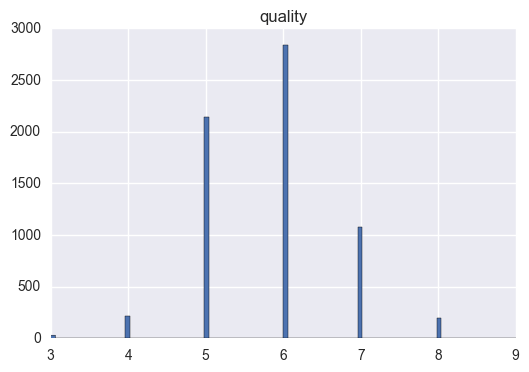

In [4]:
_ = df.hist('quality', bins=100, figsize=(6, 4))

In [5]:
df['class'] = "low"
df.loc[df.quality > 6, 'class'] = "high"

# Exploratory analysis

Visualizing dependencies

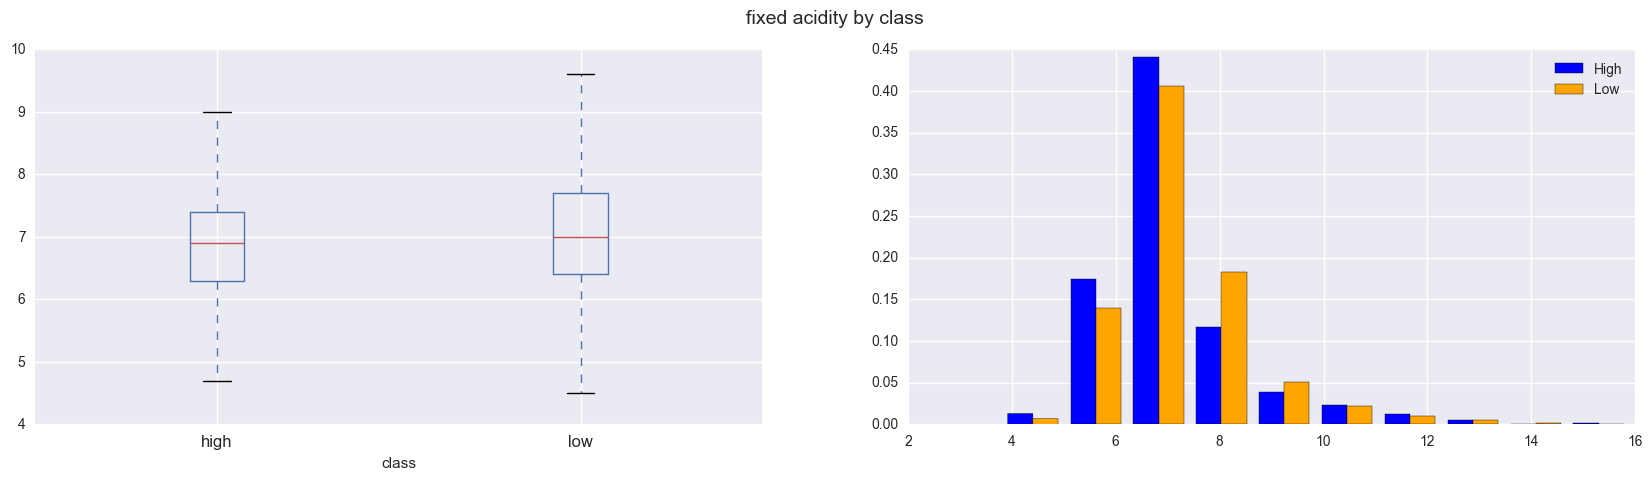

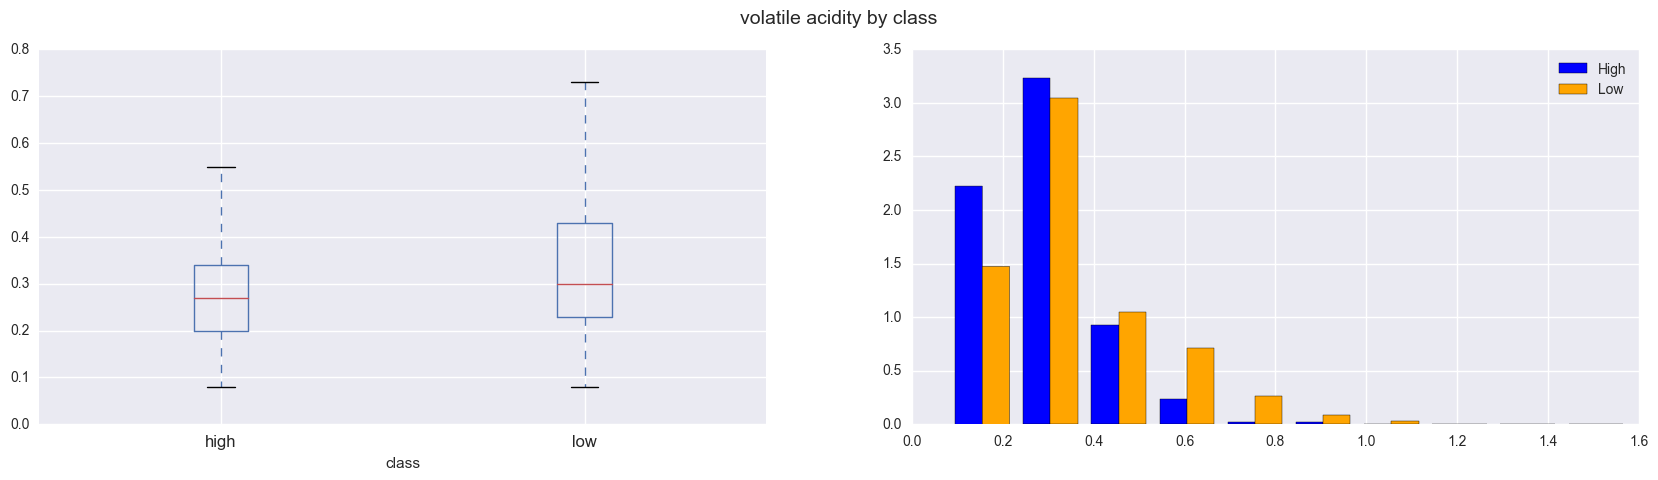

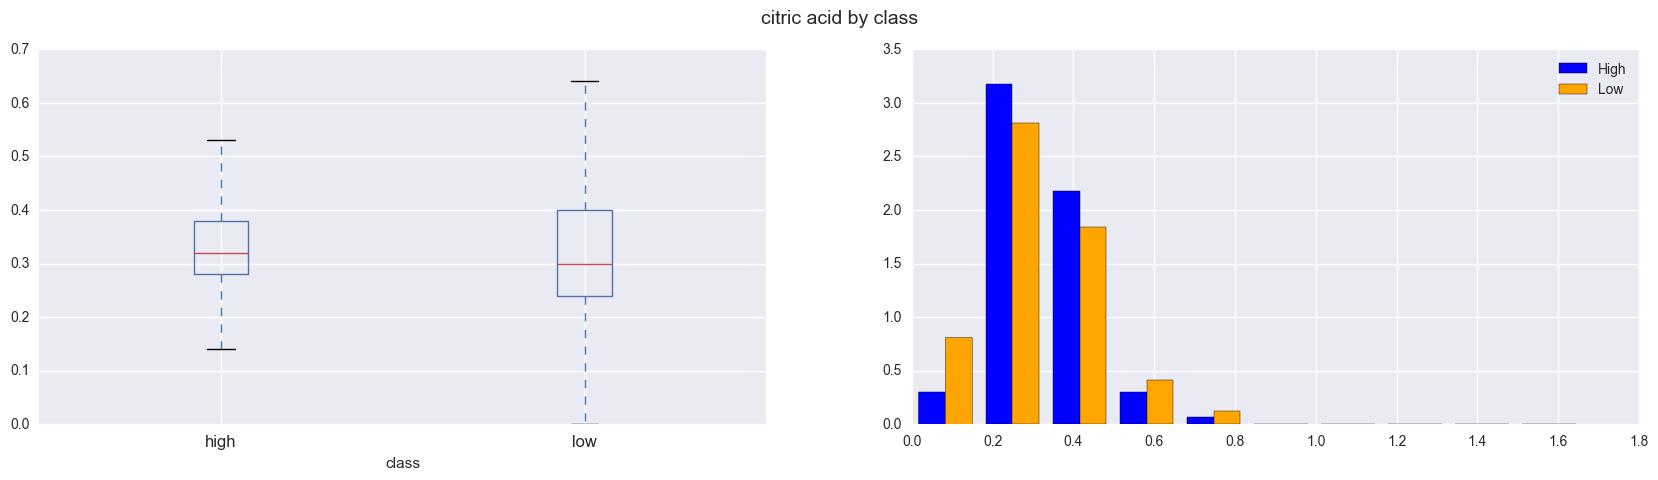

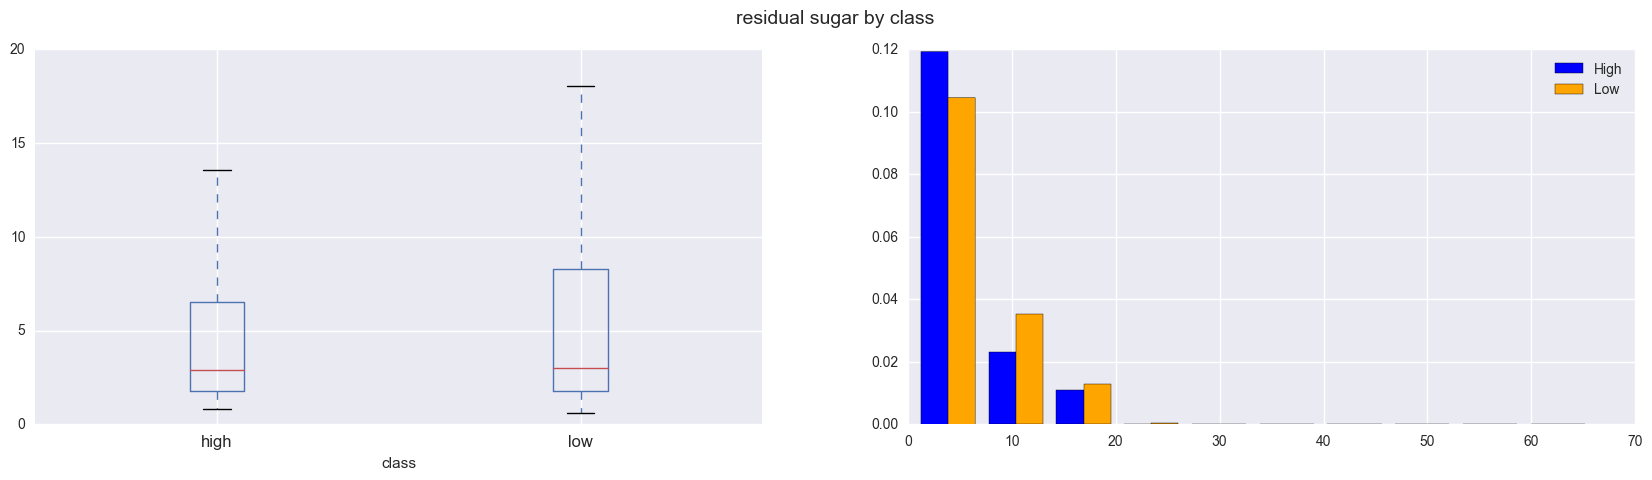

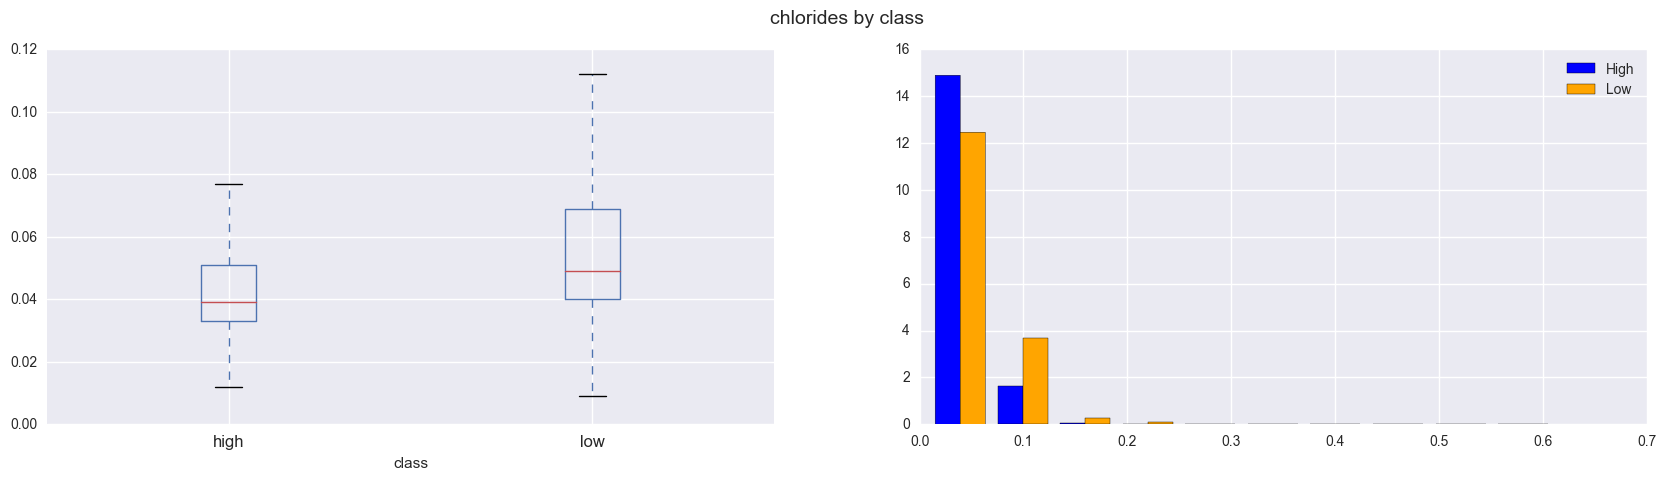

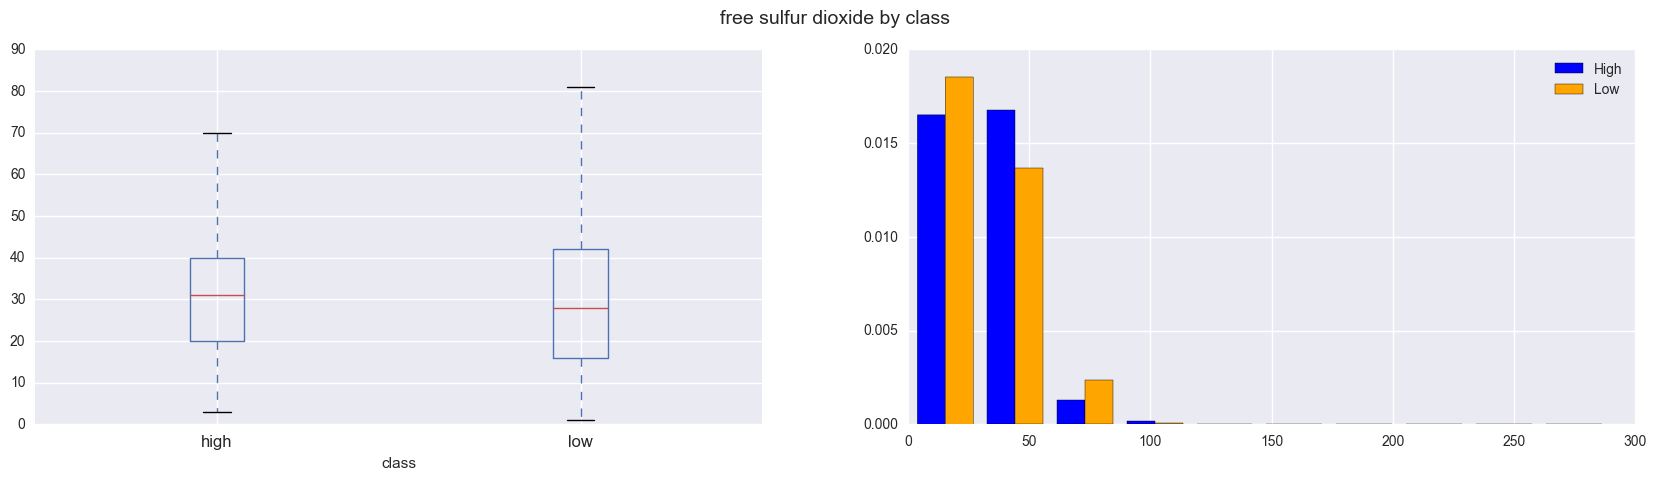

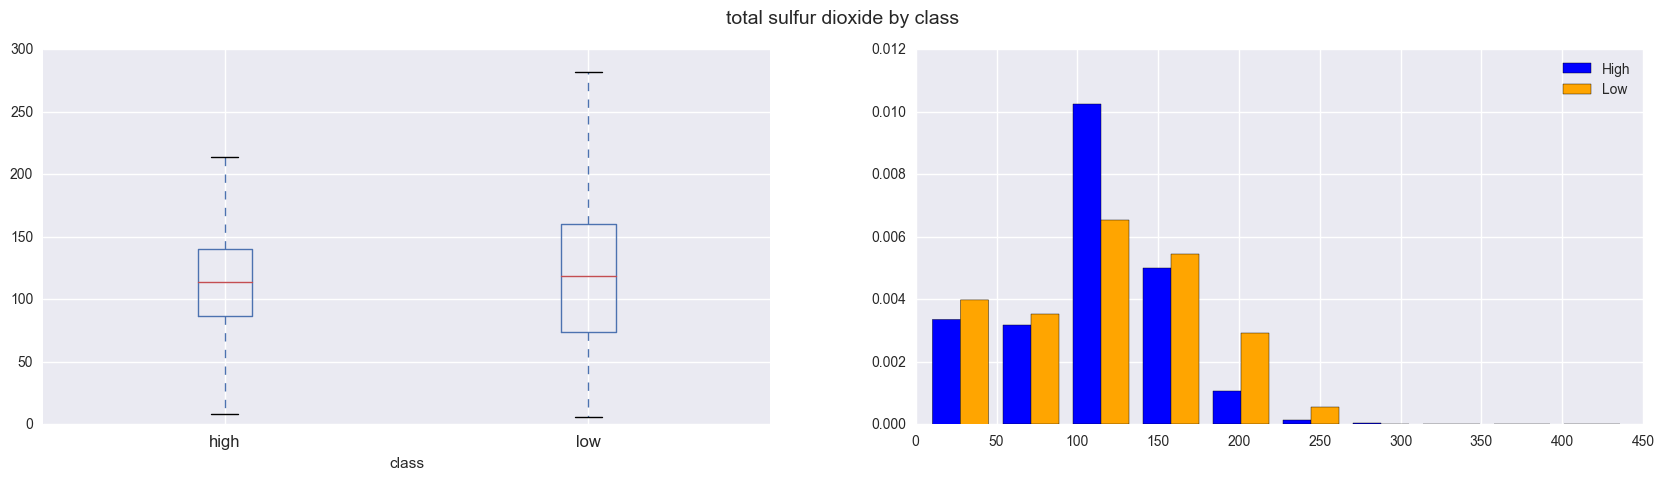

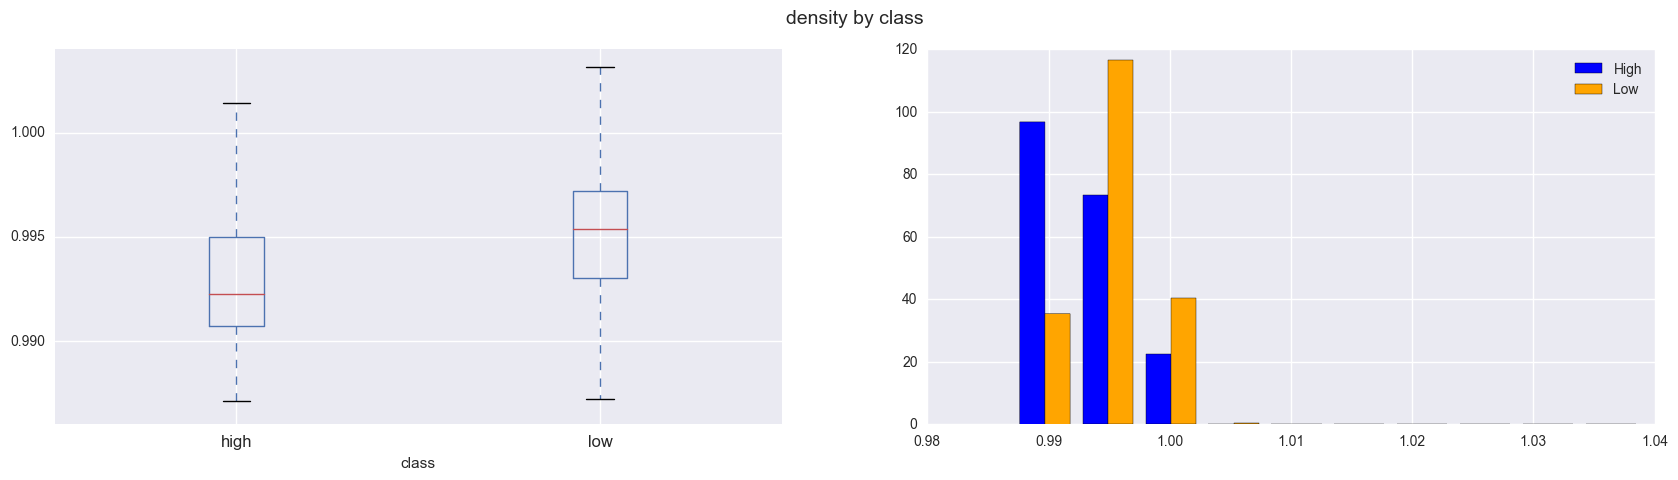

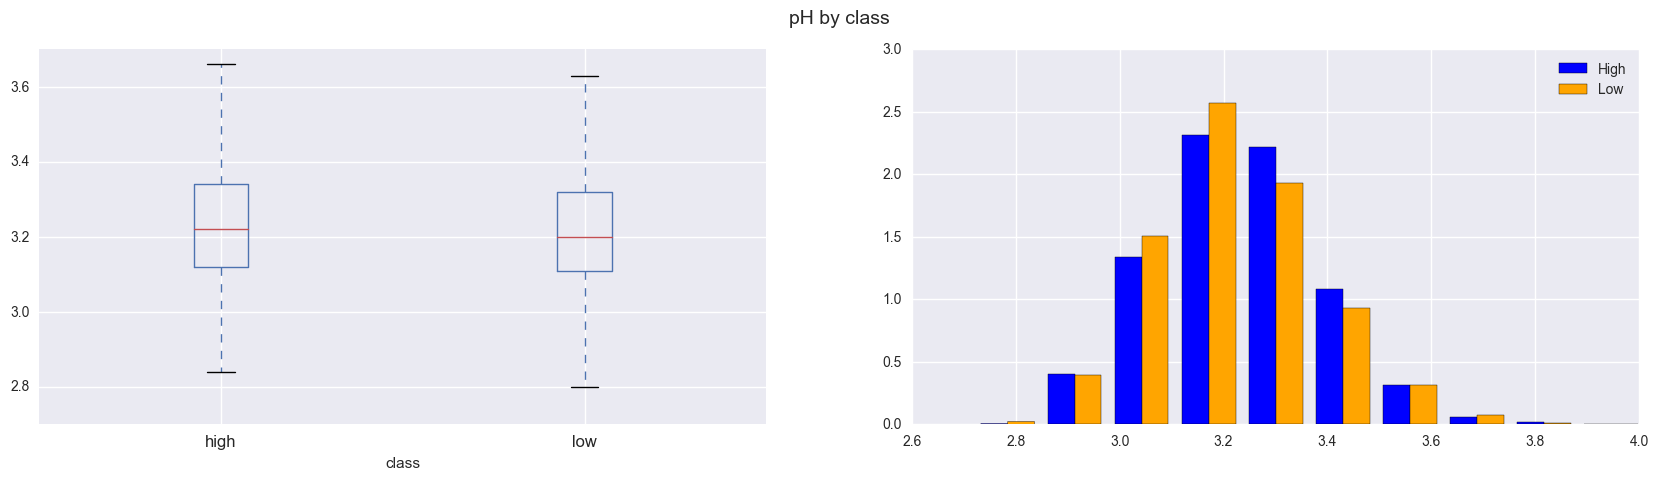

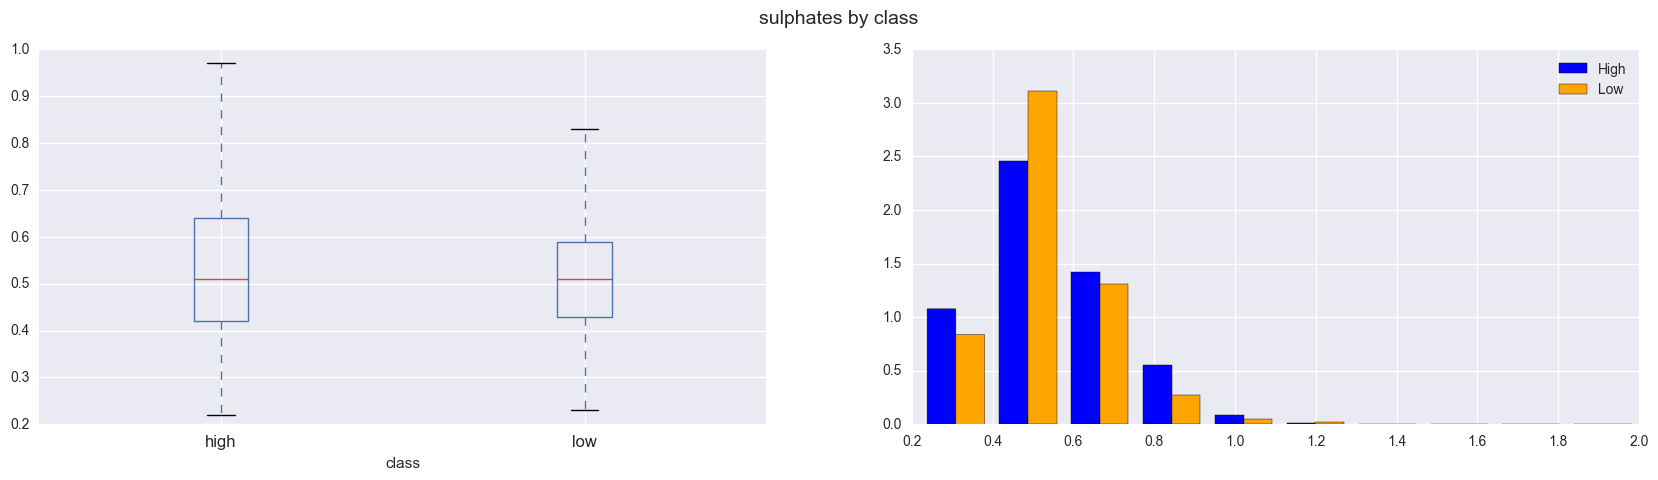

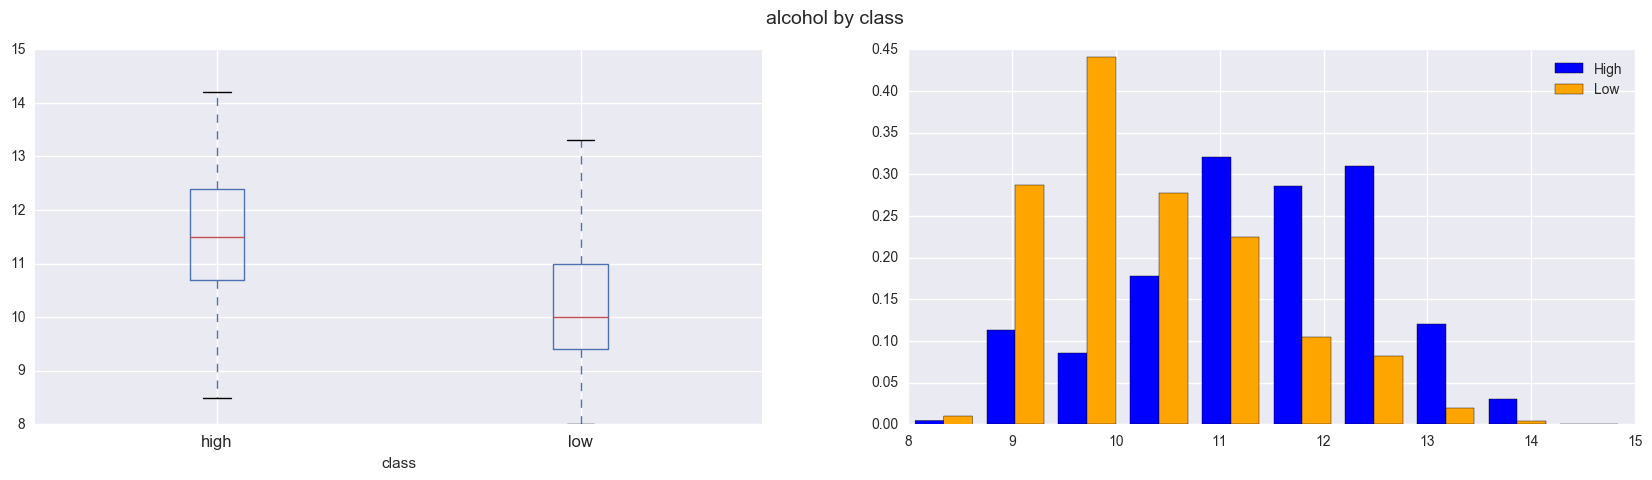

In [6]:
for column in df.columns.drop(['quality', 'color', 'class']):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    df.boxplot(column, 'class', ax=ax1, showfliers=False)
    ax1.set_title('')
    ax2.hist([df.loc[df['class'] == 'high', column], df.loc[df['class'] == 'low', column]], 
             label=['High', "Low"], color=['blue', 'orange'], normed=True)
    ax2.legend()
    fig.suptitle('{} by class'.format(column), fontsize=14)

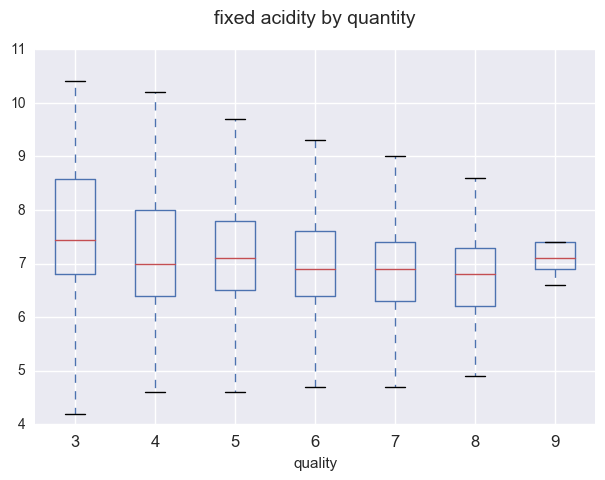

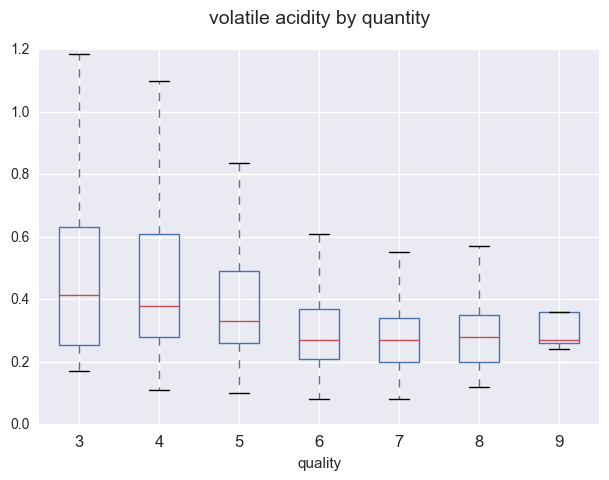

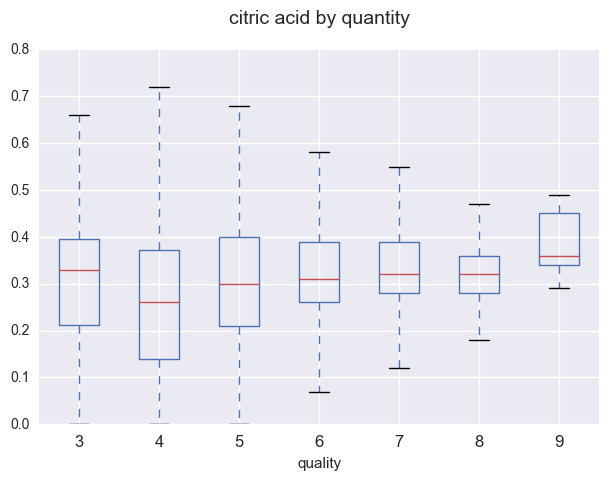

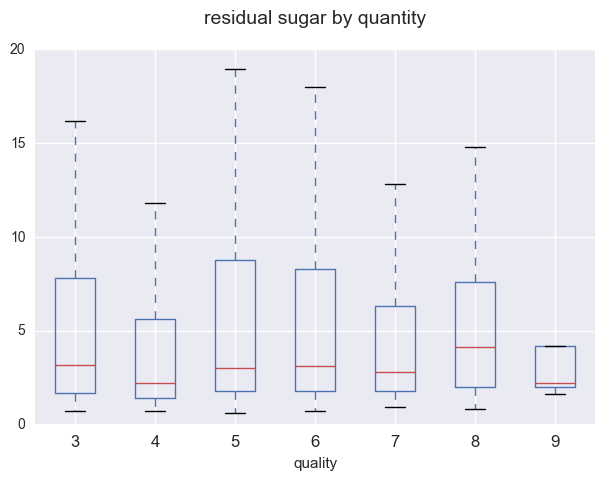

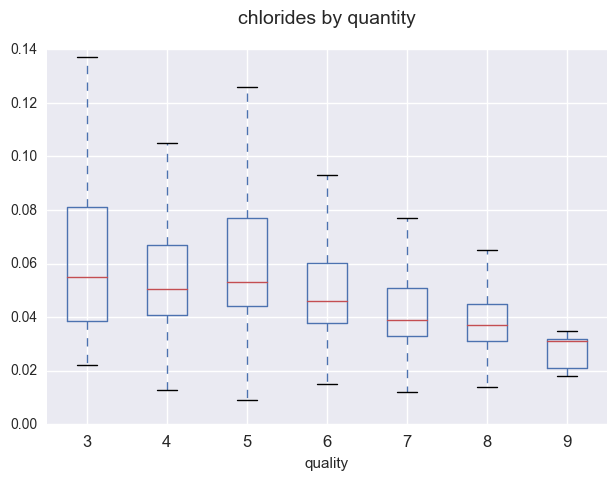

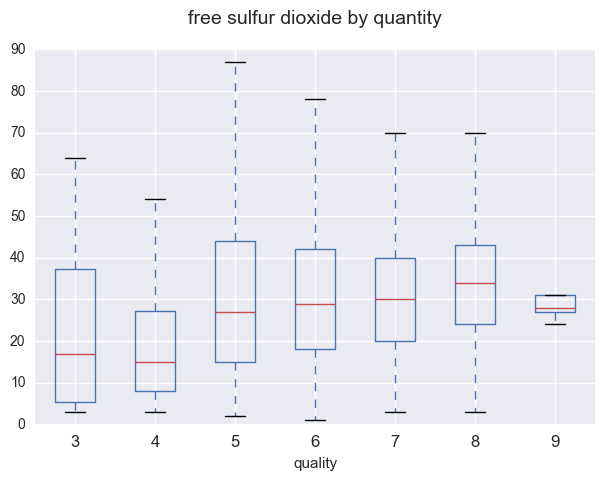

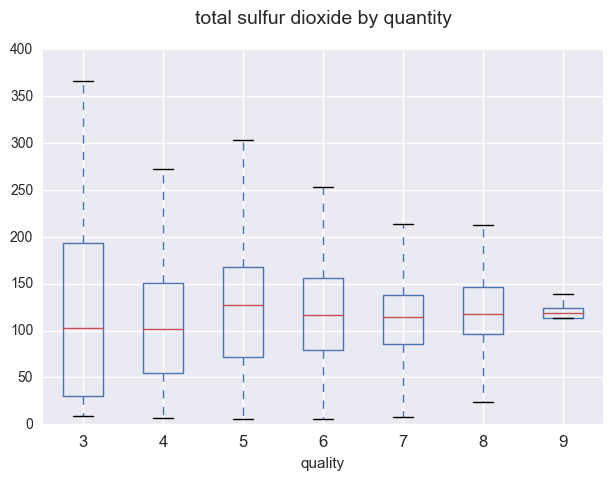

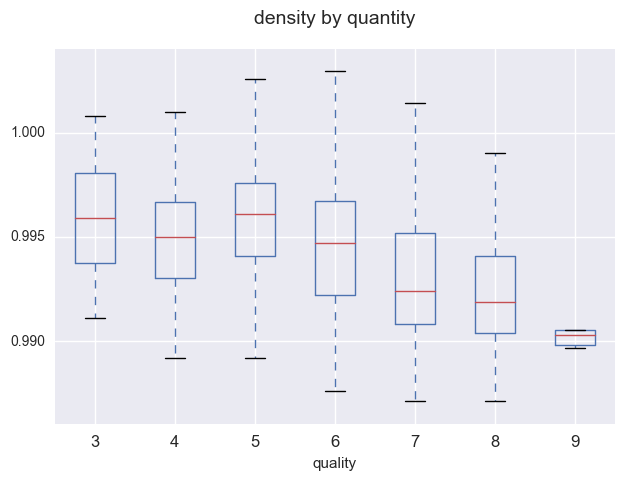

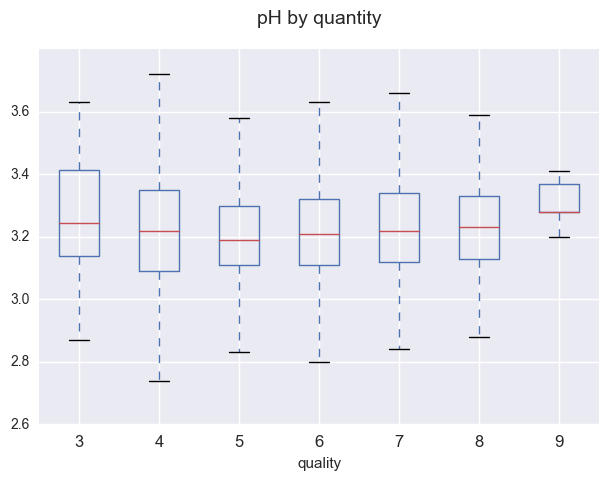

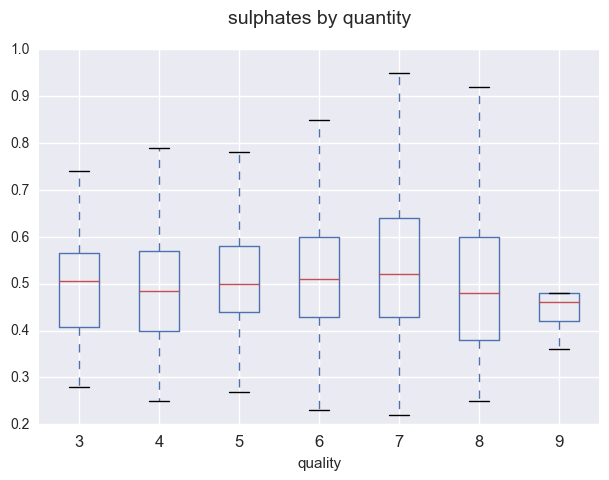

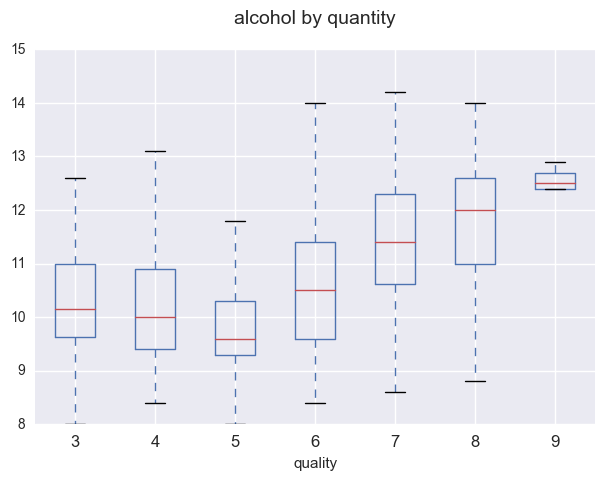

In [7]:
for column in df.columns.drop(['quality', 'color', 'class']):
    fig, ax = plt.subplots(figsize=(7,5))
    df.boxplot(column, 'quality', showfliers=False, ax=ax)
    ax.set_title('')
    fig.suptitle('{} by quantity'.format(column), fontsize=14)

Correlation

In [8]:
df.corr().style.apply(background_gradient, axis=1) \
    .set_properties(**{'max-width': '120px', 'font-size': '12pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

Predictors, most correlated with quality

In [ ]:
vals = ['volatile acidity', 'chlorides', 'density', 'alcohol']
cc = combinations(vals, 2)

In [ ]:
for k,v in combinations(vals, 2):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 7))
    sns.regplot(k,v, data=df[df['class']=='low'], fit_reg=False,  color="blue",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax1, label='high')
    ax1.legend(loc='best')
    sns.regplot(k,v, data=df[df['class']=='high'], fit_reg=False,  color="green",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax2, label='low')
    ax2.legend(loc='best')
    sns.regplot(k,v, data=df[df['class']=='low'], fit_reg=False,  color="blue",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax3, label='high')
    sns.regplot(k,v, data=df[df['class']=='high'], fit_reg=False, color="green",
               scatter_kws={'alpha':0.1, 's':200}, ax=ax3, label='low')
    ax3.legend(loc='best')

# Modelling

## Classification

### Binary

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

#### Logistic Regression

In [ ]:
lr_model = LogisticRegression(class_weight="balanced")
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
HTML(evaluate_classification(y_test, lr_pred, pos_label="high",
sample_weight=compute_sample_weight('balanced', y=y_test)))

In [ ]:
plot_roc_single(y_test, lr_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

#### Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(class_weight="balanced", min_samples_leaf=3)
#sw=compute_sample_weight('balanced', y=y_train)
#sw[sw>1]=sw[sw>1]**15
sw1=compute_sample_weight('balanced', y=y_test)

dt_model.fit(X_train, y_train)#, sample_weight=sw)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, pos_label="high", sample_weight=sw1))

In [ ]:
plot_roc_single(y_test, dt_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

#### K-NN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2,  algorithm="brute" )
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
sw1=compute_sample_weight('balanced', y=y_test)
HTML(evaluate_classification(y_test, knn_pred, pos_label="high", sample_weight=sw1))

In [ ]:
plot_roc_single(y_test, knn_model.predict_proba(X_test)[:,0], labels={'high': 1, 'low': 0})

### Multi-class

In [80]:
def convert_to_multiclass(x):
    if x == 3 or x == 4 or x == 5 :
        return "low"
    elif  x == 6:
        return "medium"
    else:
        return "high"

df.loc[:, 'class'] = df.quality.apply(convert_to_multiclass)

In [81]:
df['class'].value_counts()

medium    2836
low       2384
high      1277
Name: class, dtype: int64

In [82]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['class'].values)

#### Logistic Regression


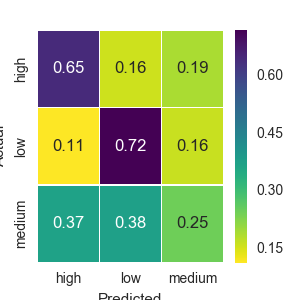

In [285]:
lr_model = LogisticRegression(multi_class="multinomial", solver="lbfgs", class_weight="balanced", max_iter=100)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
HTML(evaluate_classification(y_test, lr_pred, average="macro", fs=3))

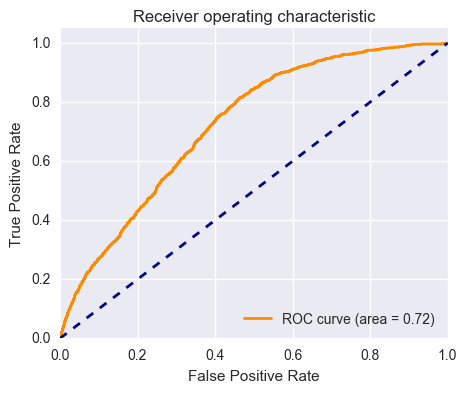

In [284]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), lr_model.decision_function(X_test), fsize=[5,4])

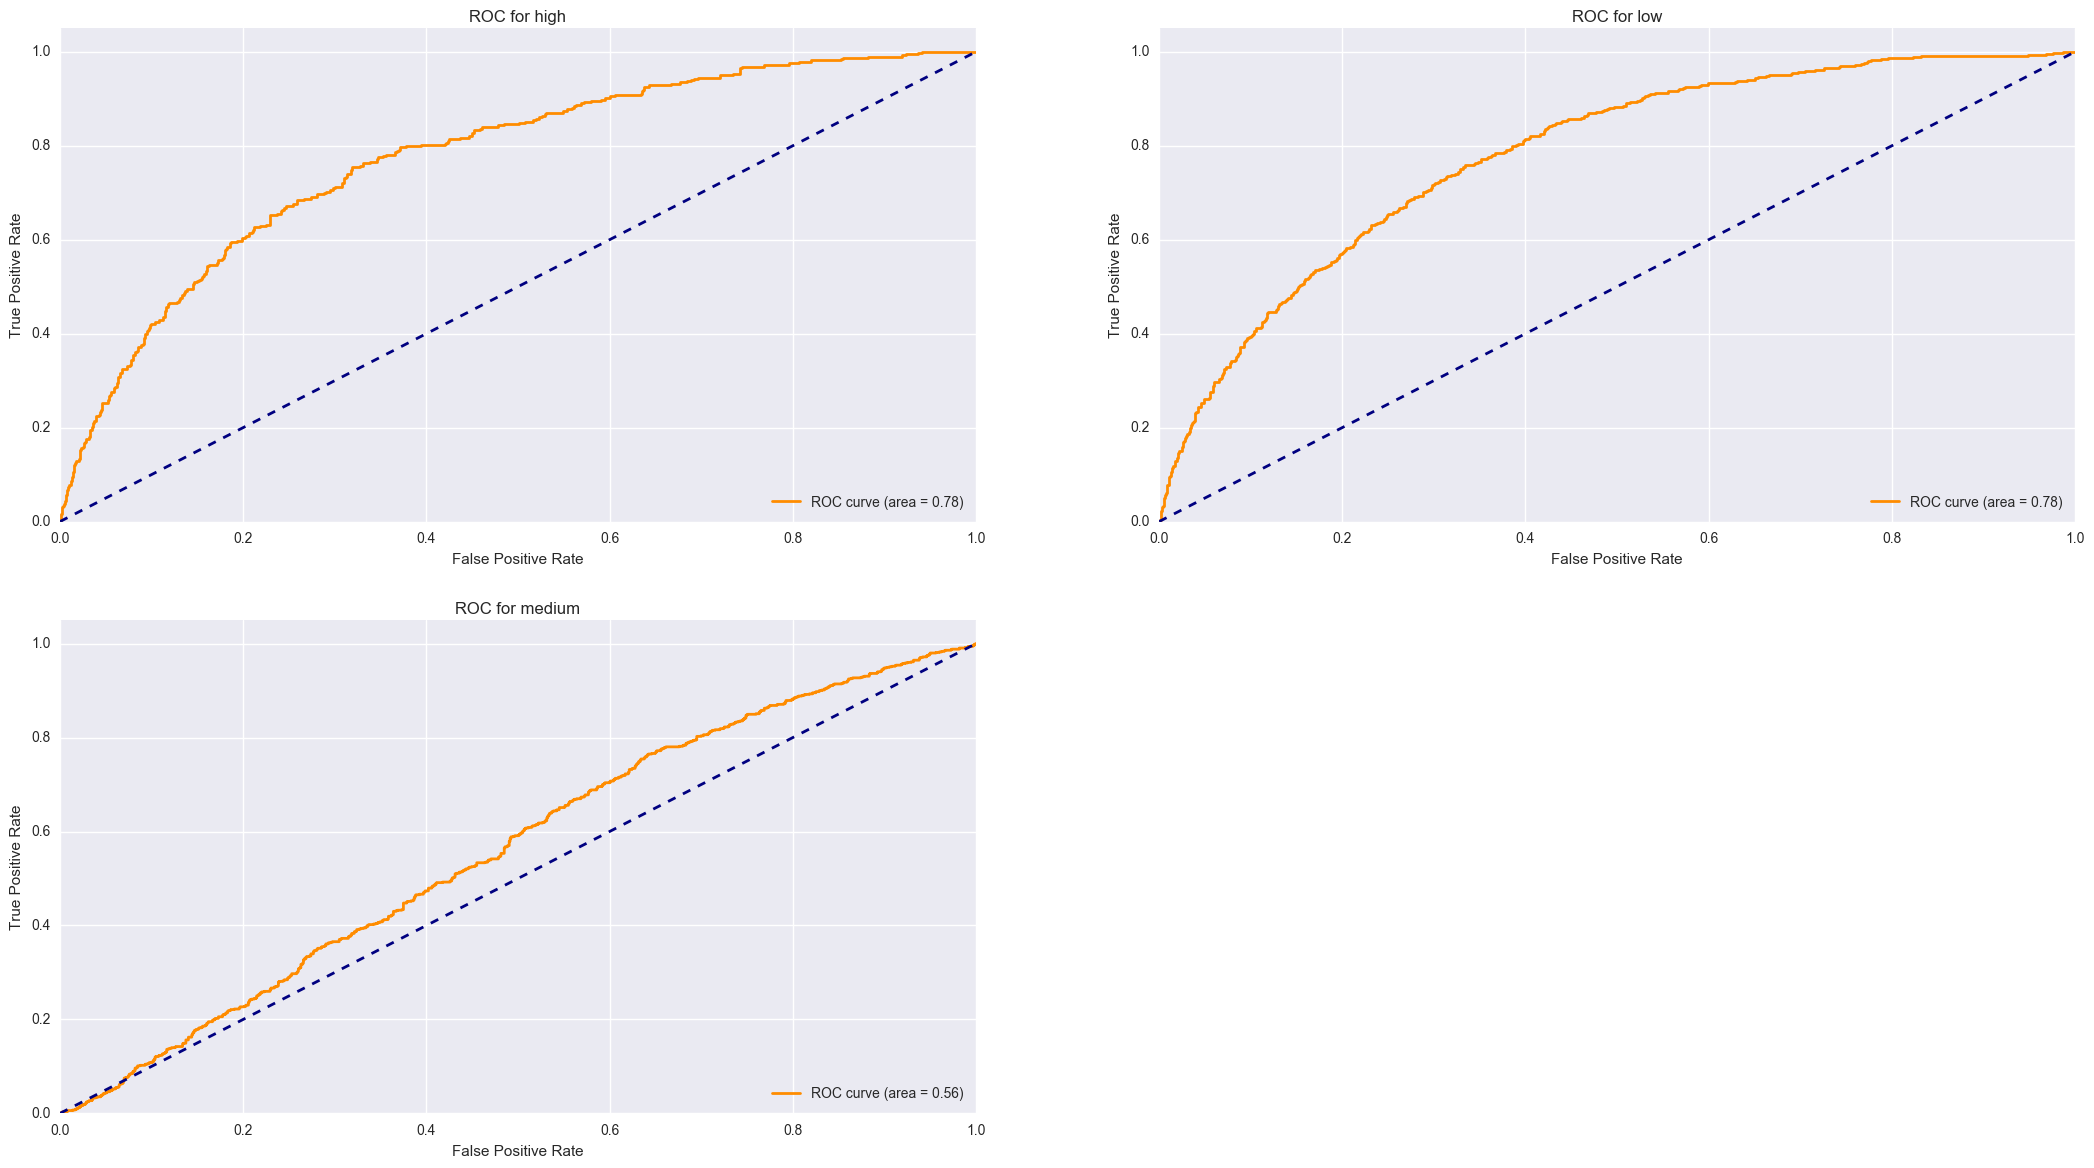

In [89]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), lr_model.decision_function(X_test), titles=np.unique(y_test))

#### Decision Tree


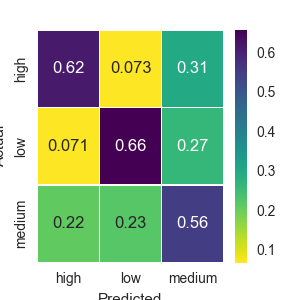

In [281]:
dt_model = DecisionTreeClassifier(class_weight="balanced", min_samples_leaf=3, criterion='gini')
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
HTML(evaluate_classification(y_test, dt_pred, average="micro", fs=3))

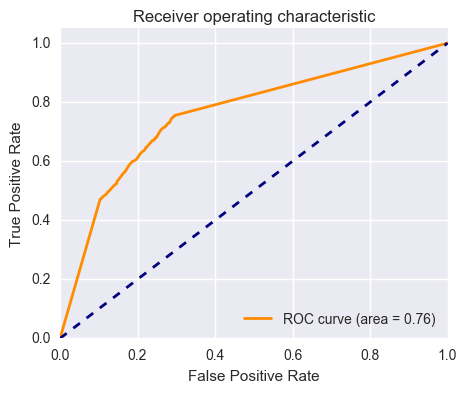

In [283]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), dt_model.predict_proba(X_test), fsize=[5,4])

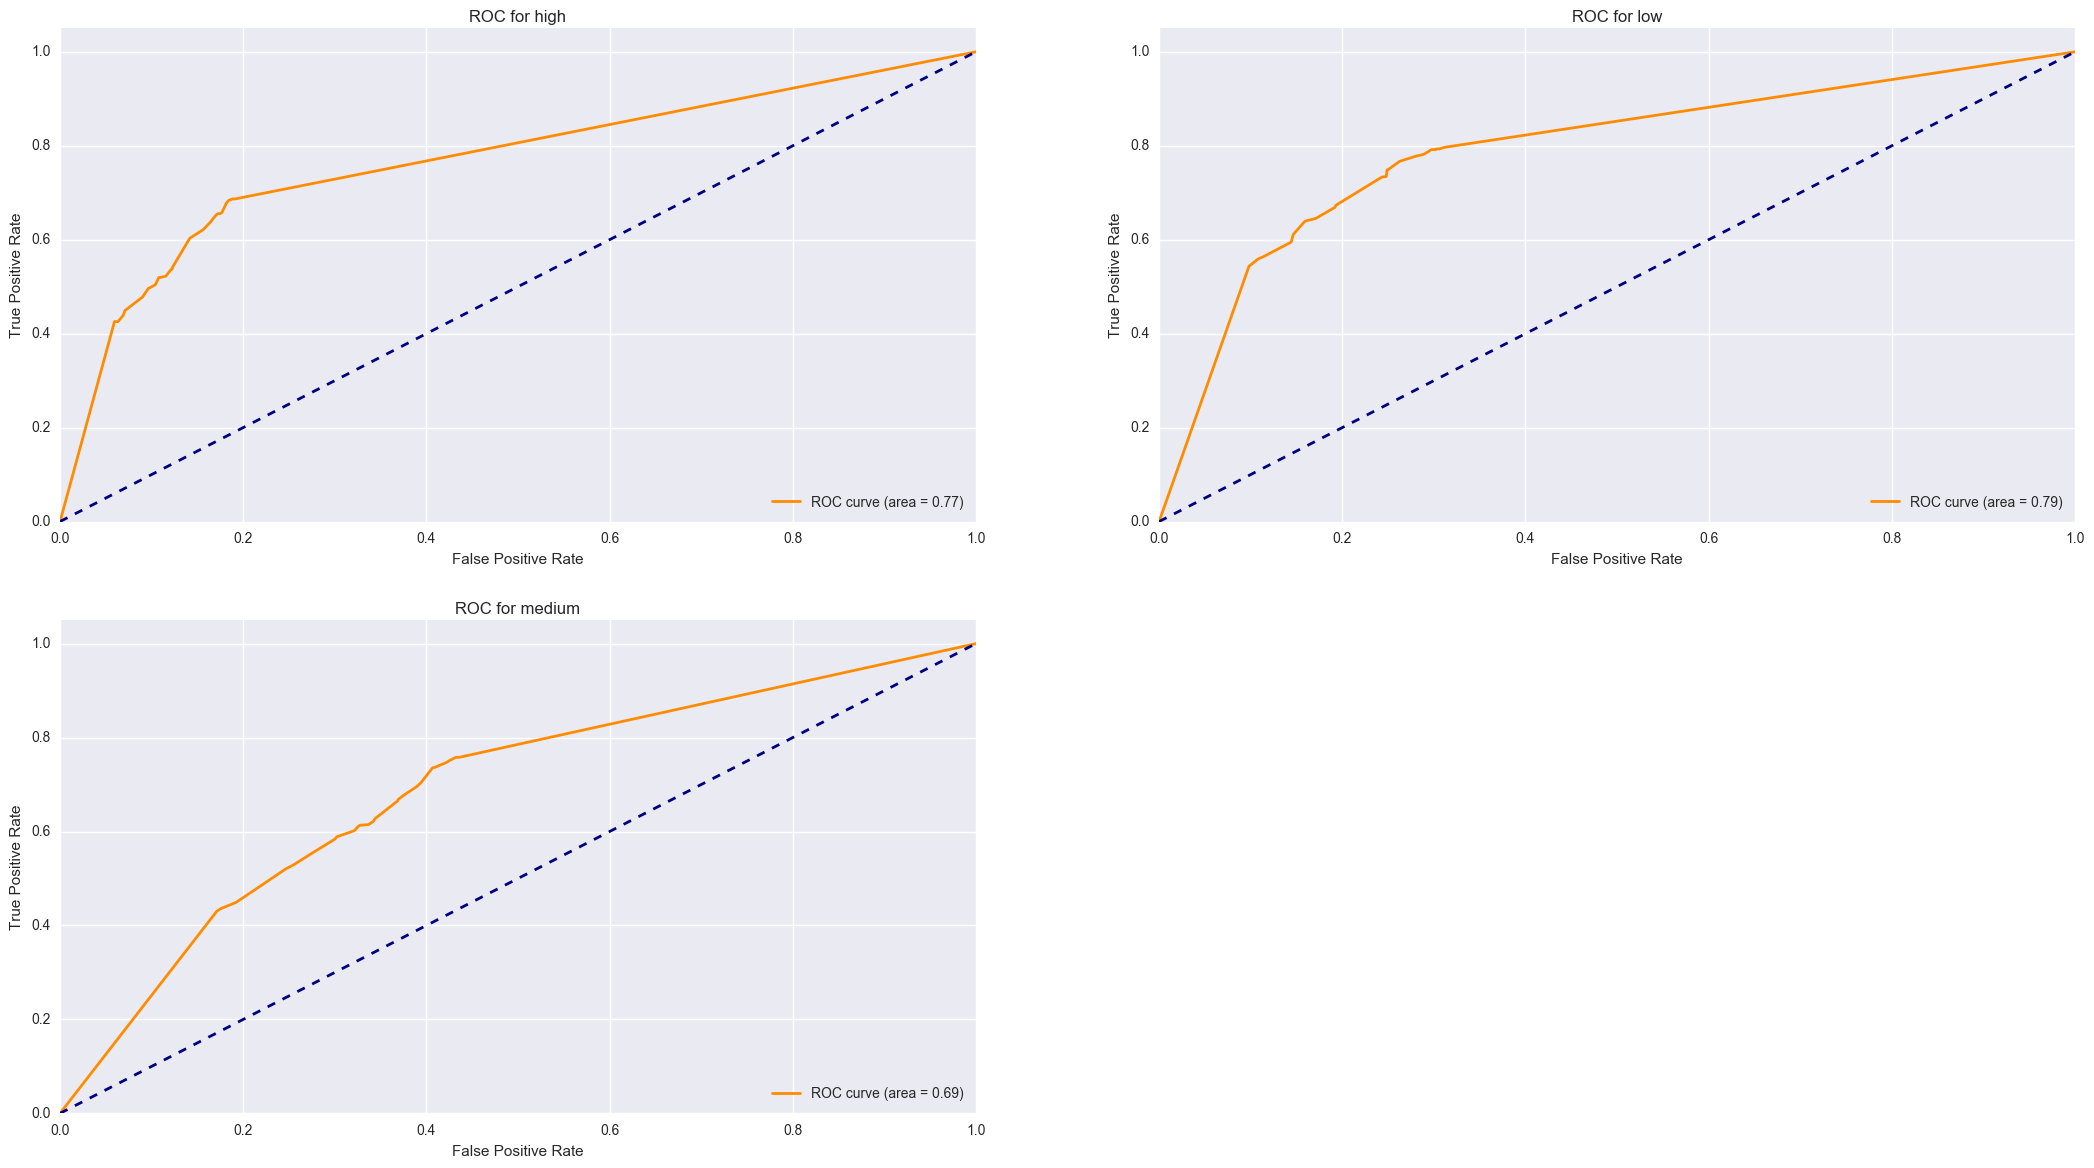

In [96]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), dt_model.predict_proba(X_test), titles=np.unique(y_test))

#### K-NN


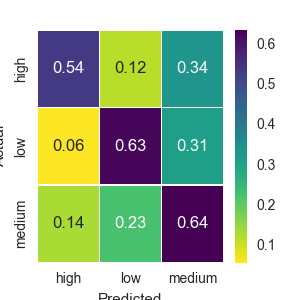

In [275]:
knn_model = KNeighborsClassifier(n_neighbors=5, algorithm='brute', weights='distance', metric='cosine')
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
HTML(evaluate_classification(y_test, knn_pred, average="macro", fs=3))

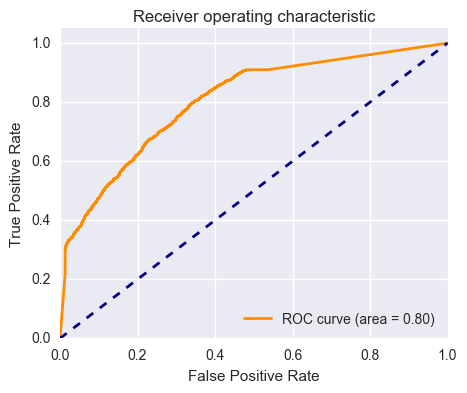

In [272]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), knn_model.predict_proba(X_test), fsize=[5,4])

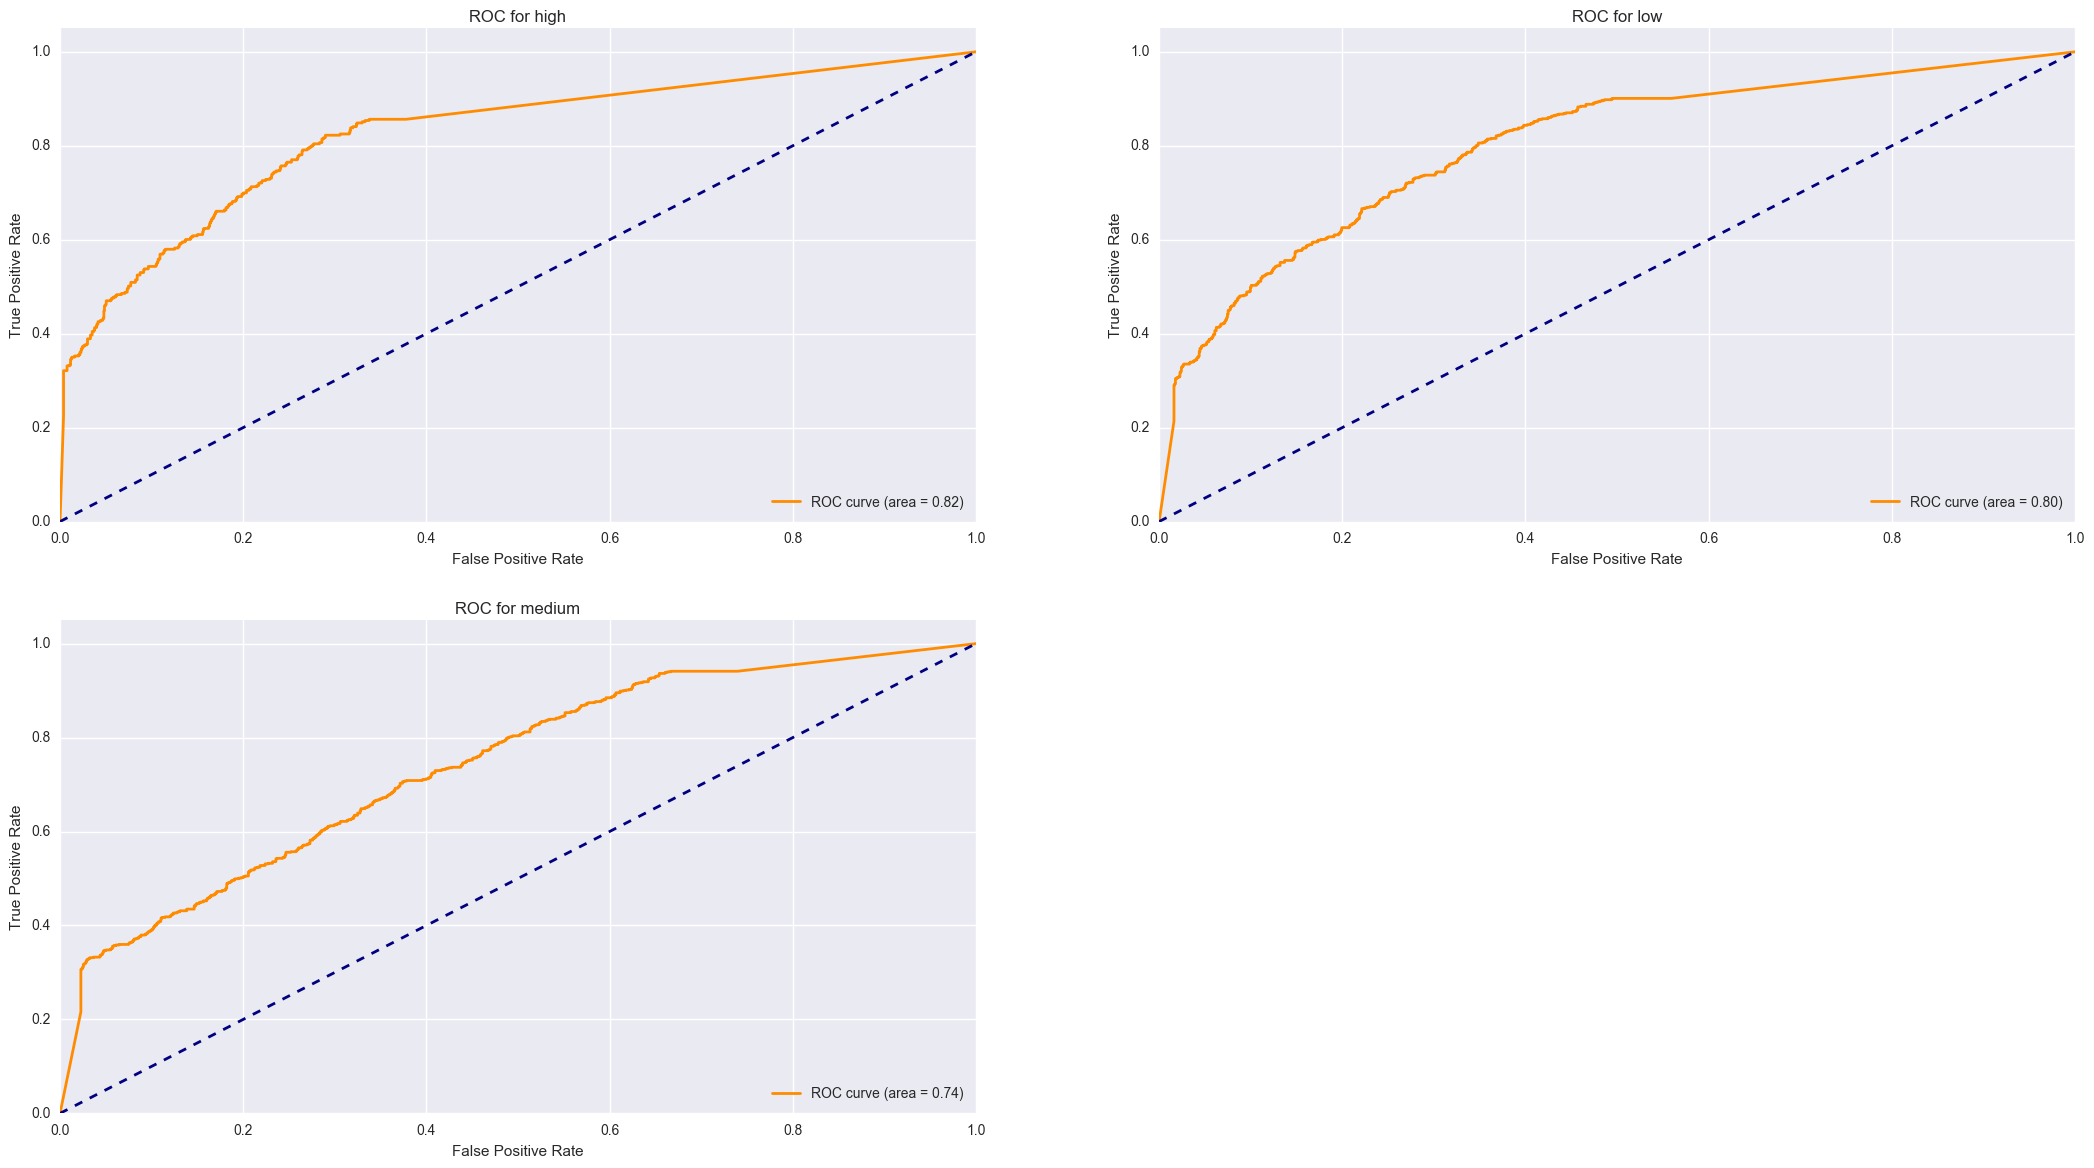

In [273]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), knn_model.predict_proba(X_test), titles=np.unique(y_test))

### Ensemble

In [268]:
def f(x):
    dc=np.array(['high','low','medium'])
    pred_pr=dt_pred*x[0]+knn_pred*x[1]+lr_pred*x[2]
    pred=pred_pr.argmax(axis=1)
    m=np.array(confusion_matrix_simple(y_test,pred))
    return (1-m.diagonal().min())
def opt():
    acc=[]
    X=[]
    for k in range(20):
        x0=k/20.0
        for k1 in range(20-k-1):
            x1=k1/20.0
            x2=1-x0-x1
            acc.append(f([x0,x1,x2]))
            X.append([x0,x1,x2])
            
    return(acc, X)
    


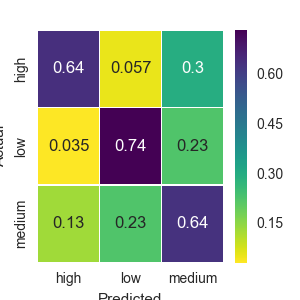

In [276]:
dc=np.array(['high','low','medium'])

knn_pred = knn_model.predict_proba(X_test)
dt_pred=dt_model.predict_proba(X_test)
lr_pred = lr_model.predict_proba(X_test)

res, coeff =opt()
res=np.array(res)
cf=coeff[res.argmin()]
pred_pr=(dt_pred*cf[0]+knn_pred*cf[1]+lr_pred*cf[2])
pred=pred_pr.argmax(axis=1)

pred=dc[pred]
HTML(evaluate_classification(y_test, pred, average="macro", fs=3))

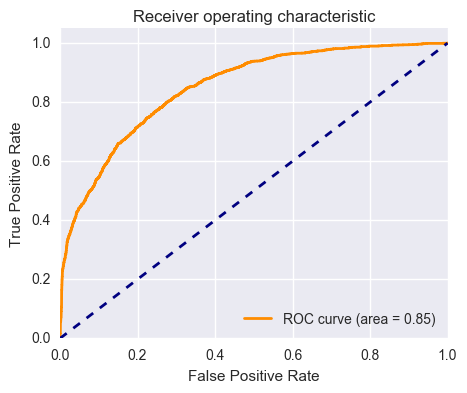

In [278]:
plot_roc_single(pd.get_dummies(y_test).as_matrix(), pred_pr, fsize=[5,4])

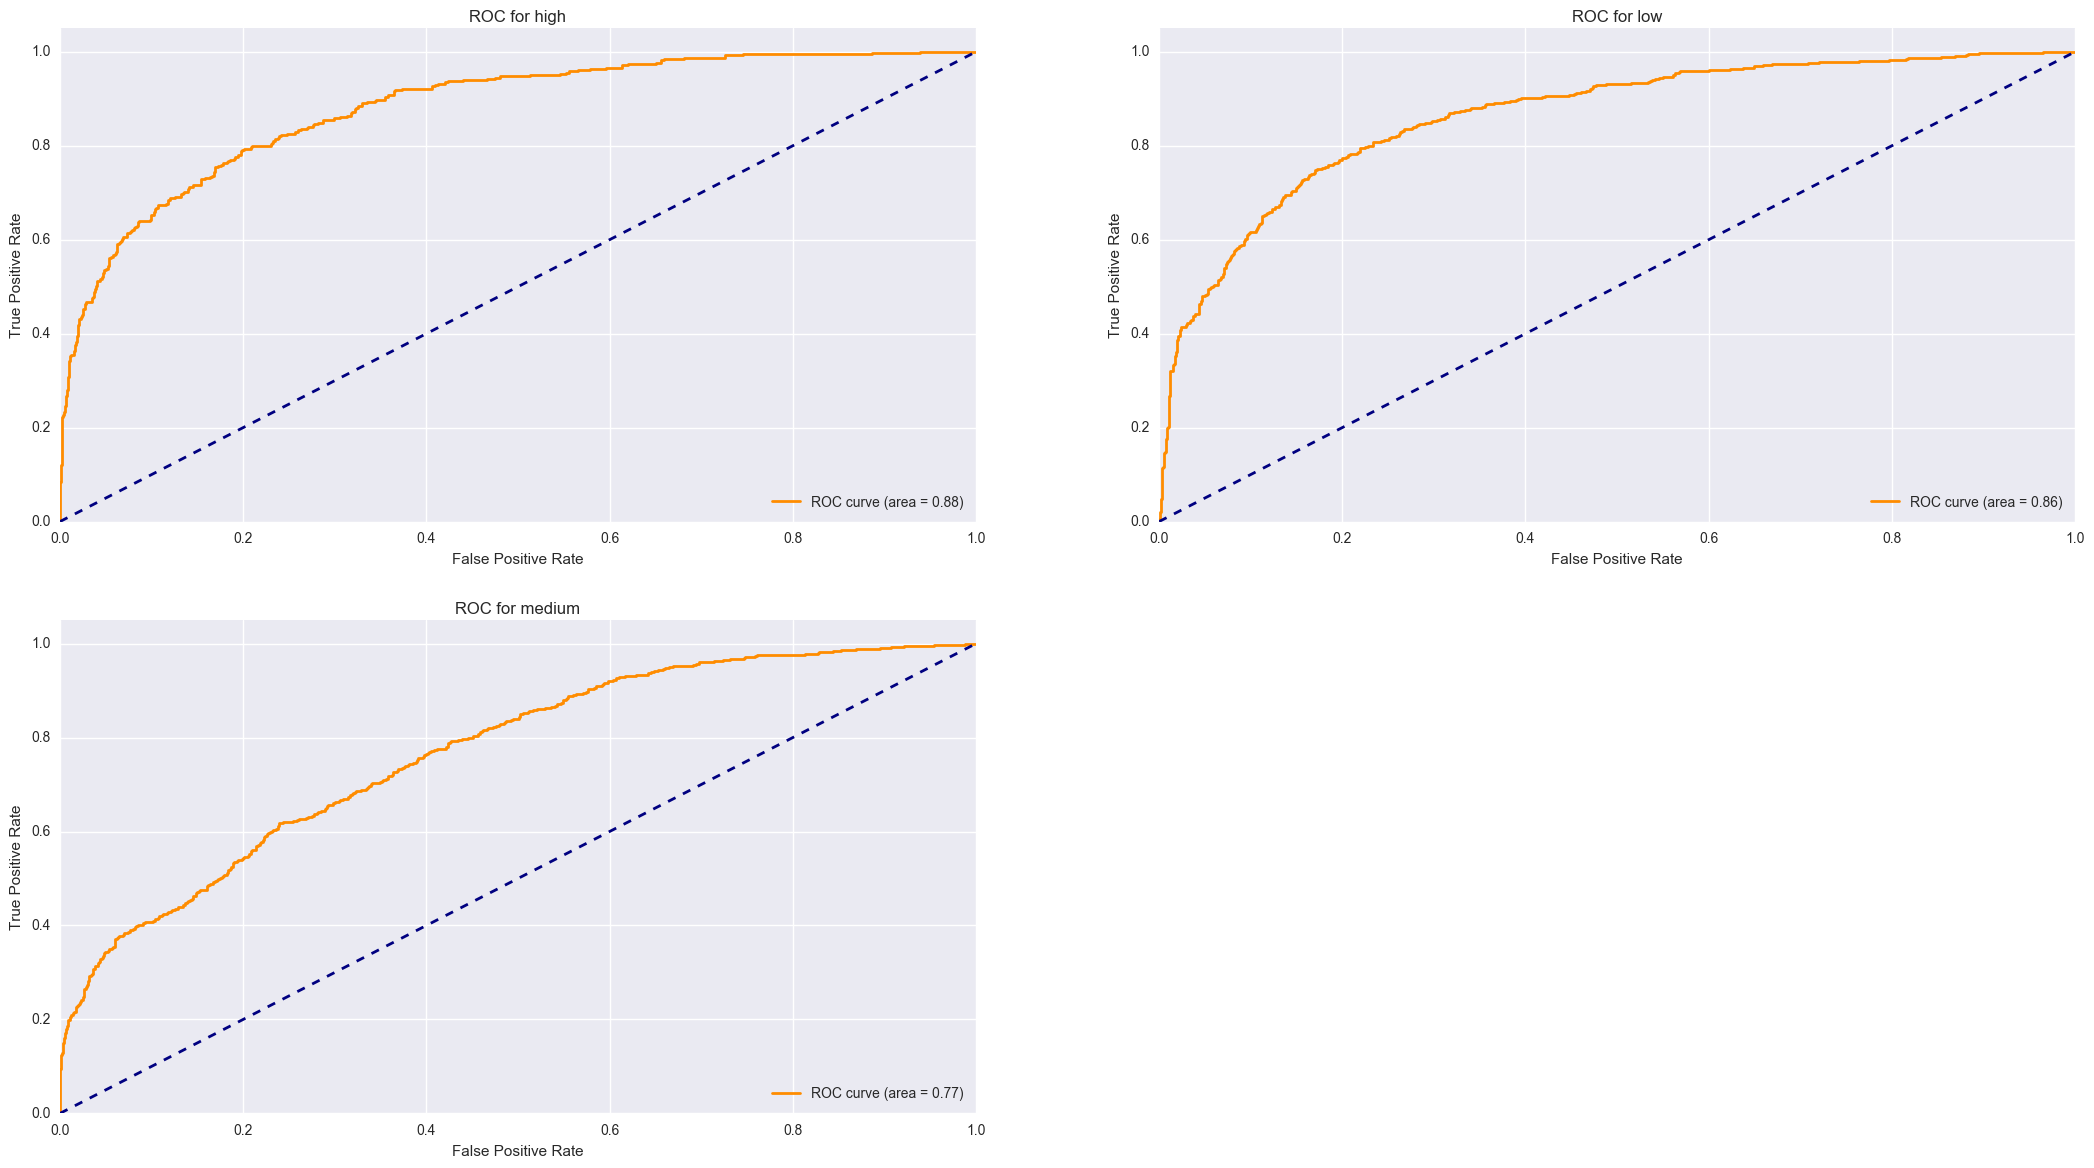

In [279]:
plot_roc_multiple(pd.get_dummies(y_test).as_matrix(), pred_pr, titles=np.unique(y_test))

## Regression

### OLS

In [ ]:
X = df.drop(['class', 'color', 'quality'], axis=1).as_matrix()
y = df['quality'].values
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(df.drop(['class', 'color', 'quality'], axis=1).as_matrix(), df['quality'].values)

### Linear regression

In [ ]:
lnr_model = LinearRegression()
sw=compute_sample_weight('balanced', y=y_train)
lnr_model.fit(X_train, y_train, sw)
lnr_pred = lnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, lnr_pred, sample_weight=sw)

In [ ]:
plt.scatter(y_test, lnr_pred, alpha=0.1)
plt.show()

### Polynomial regression

In [ ]:
pnr_model = Pipeline([('polynom', PolynomialFeatures()), ('linreg', LinearRegression())])
sw=compute_sample_weight('balanced', y=y_train)
pnr_model.fit(X_train, y_train, **{'linreg__sample_weight': sw})
pnr_pred = pnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, pnr_pred, sample_weight=sw)

In [ ]:
plt.scatter(y_test, lnr_pred, alpha=0.1)
plt.show()

### Decision Tree

In [ ]:
dtr_model = DecisionTreeRegressor(min_samples_leaf=3)
sw=compute_sample_weight('balanced', y=y_train)
dtr_model.fit(X_train, y_train, sample_weight=sw)
dtr_pred = dtr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, dtr_pred, sample_weight=sw)

### K-NN

In [ ]:
knnr_model = KNeighborsRegressor(n_neighbors=2, weights='distance', algorithm='brute', metric='cosine')
knnr_model.fit(X_train, y_train)
knnr_pred = knnr_model.predict(X_test)
sw=compute_sample_weight('balanced', y=y_test)
evaluate_regression(y_test, knnr_pred,sample_weight=sw)

# Clustering

### Prepare data

In [20]:
X = df.drop(['class', 'color', 'quality'], axis=1).as_matrix()
X = StandardScaler().fit_transform(X)
y = df['class'].values

In [21]:
df['class'].value_counts()

medium    2836
low       2384
high      1277
Name: class, dtype: int64

### K-Means

In [ ]:
scores = []
for nclust in range(2,20):
    kmeans = KMeans(n_clusters=nclust, random_state=42)
    kmeans.fit(X)
    scores.append(metrics.silhouette_score(X, kmeans.labels_))

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), scores)
plt.grid(True)
plt.xlim(2,19)
plt.title('Silhouette scores')

In [ ]:
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.xlim(2,19)
plt.title('Elbow curve')

### Hierarchical clustering

In [13]:
def evaluate_hclust_test(y, link):
    amis, chs, ss, vs = [], [], [], []
    for k in range(2,51):
        clusters = fcluster(link, k, 'maxclust')
        amis.append(metrics.adjusted_mutual_info_score(y, clusters))
        chs.append(metrics.calinski_harabaz_score(X, clusters))
        ss.append(metrics.silhouette_score(X, clusters))
        vs.append(metrics.v_measure_score(y, clusters))
    
    fig, rows = plt.subplots(2, 2, figsize=(15,10))
    rows[0][0].plot(range(2,51), amis)
    rows[0][0].set_xlim(2,50)
    rows[0][0].set_title("adjusted mutual info score")
    rows[0][1].plot(range(2,51), chs)
    rows[0][1].set_xlim(2,50)
    rows[0][1].set_title("calinski harabas score")
    rows[1][0].plot(range(2,51), vs)
    rows[1][0].set_xlim(2,50)
    rows[1][0].set_title("v-score")
    rows[1][1].plot(range(2,51), ss)
    rows[1][1].set_xlim(2,50)
    rows[1][1].set_title("silhouette score")

#### Single

In [9]:
single = linkage(pdist(X), 'single')

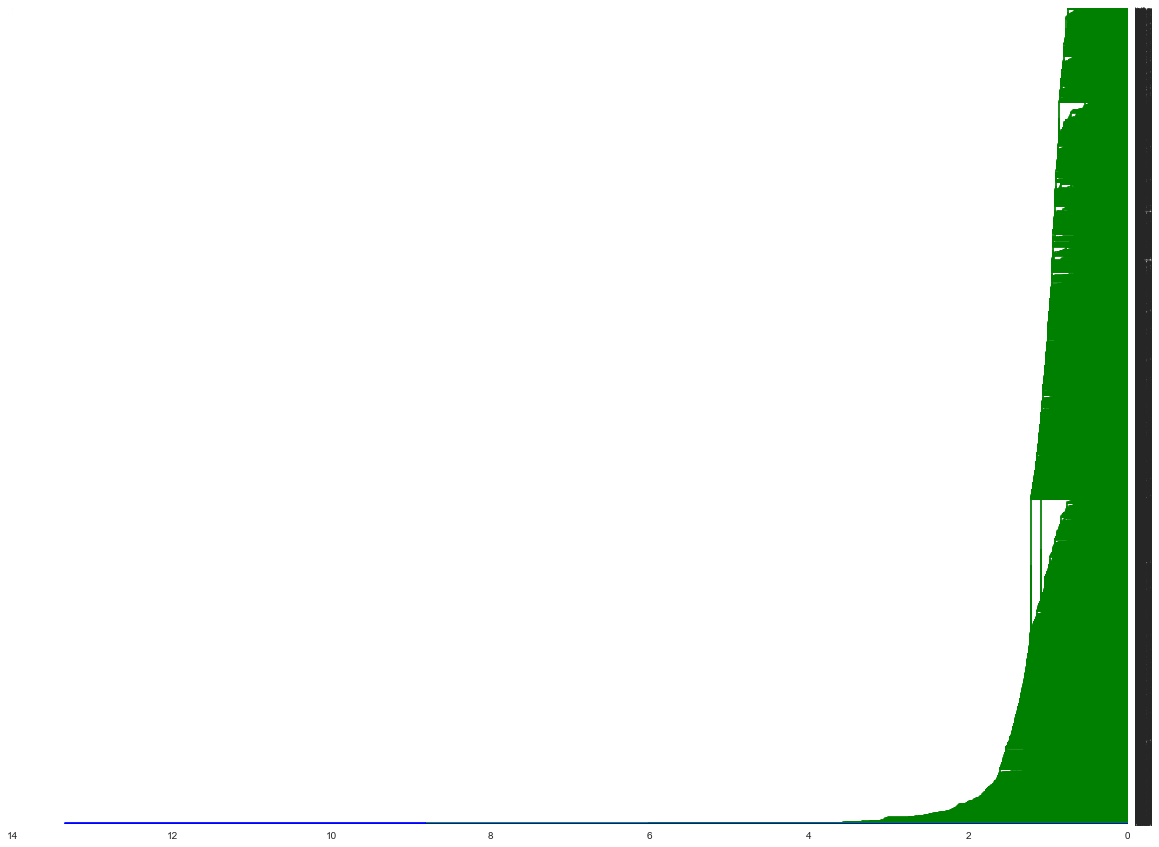

In [10]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(single, orientation='left', labels=y, ax=ax)

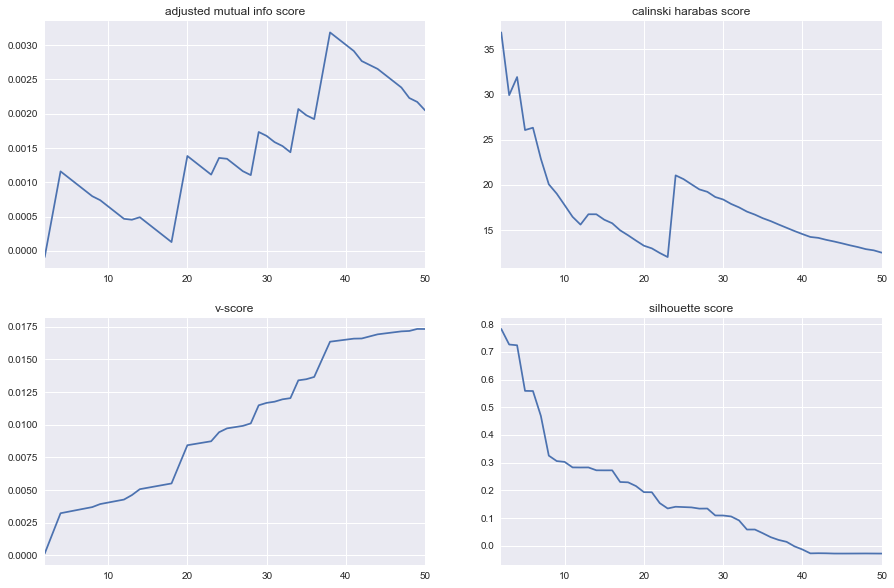

In [11]:
evaluate_hclust_test(y, single)

#### Average

In [12]:
average = linkage(pdist(X), 'average')

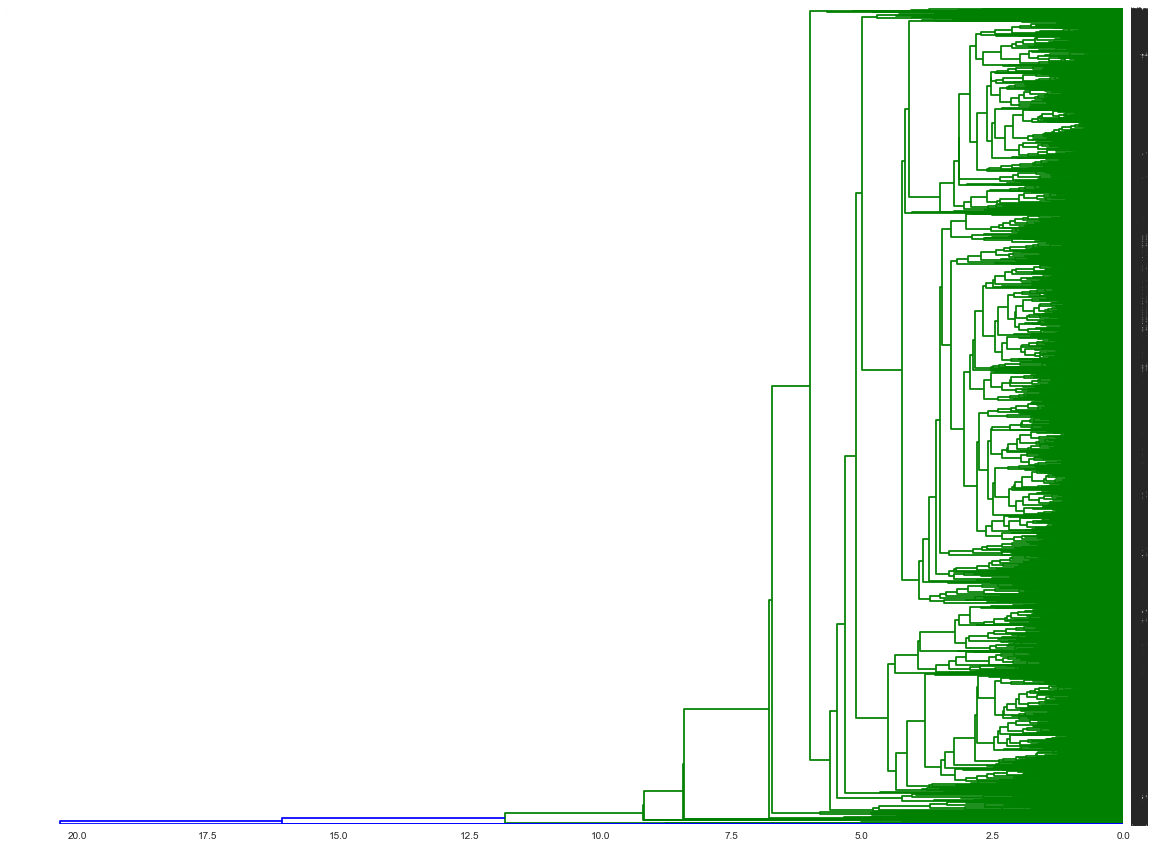

In [13]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(average, orientation='left', labels=y, ax=ax)

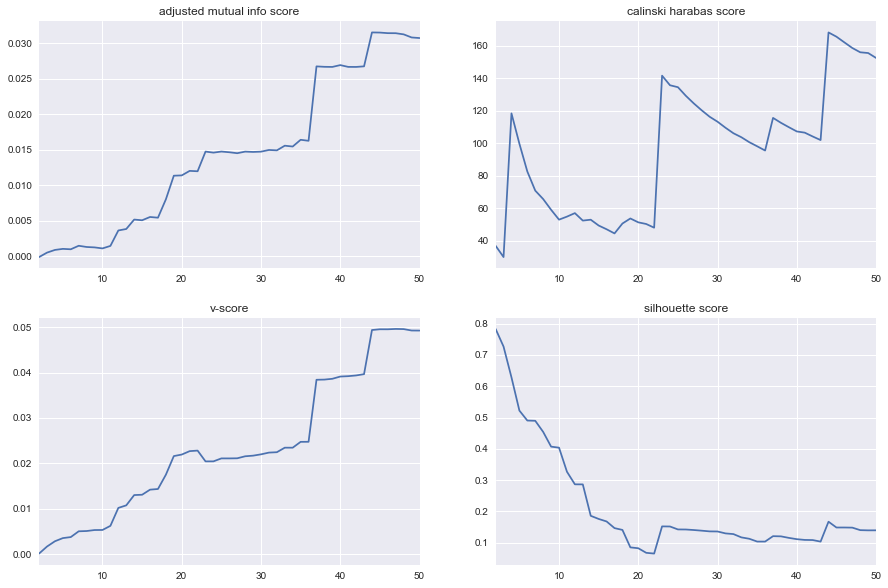

In [14]:
evaluate_hclust(y, average)

#### Complete

In [15]:
complete = linkage(pdist(X), 'complete')

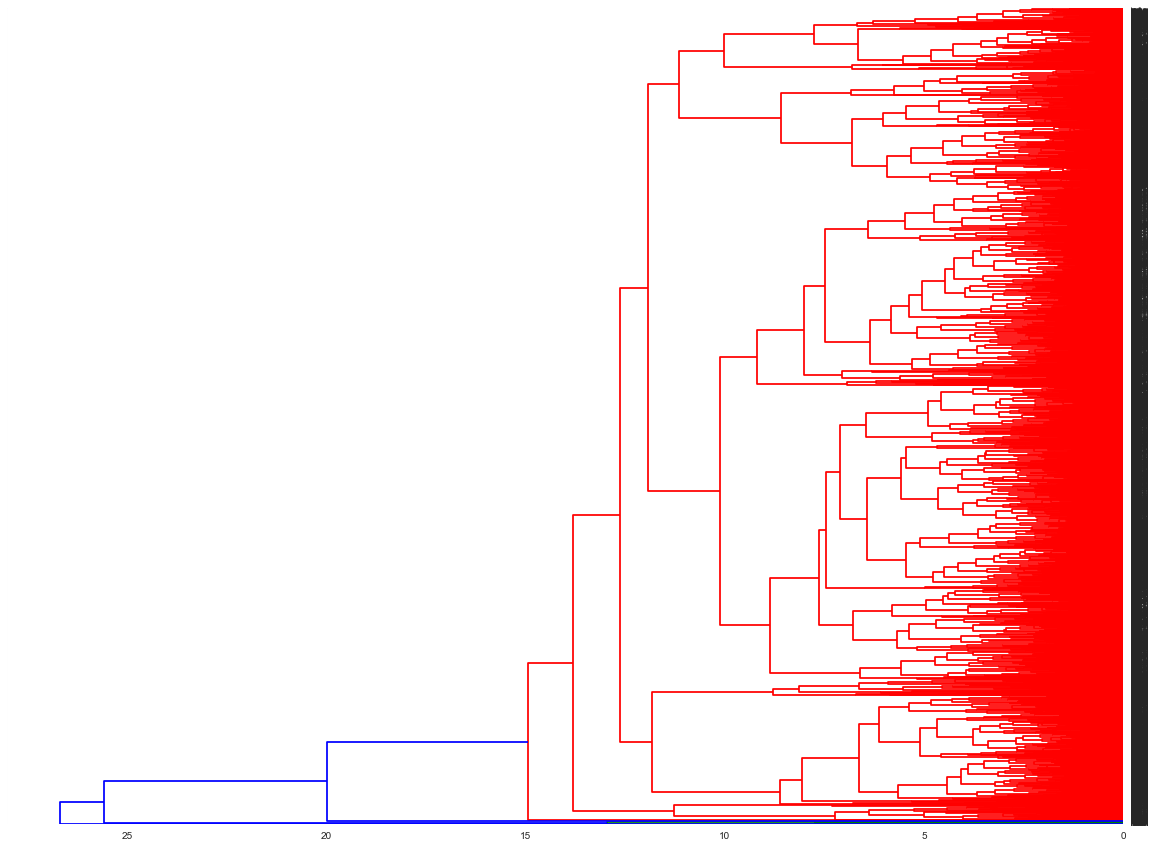

In [16]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(complete, orientation='left', labels=y, ax=ax)

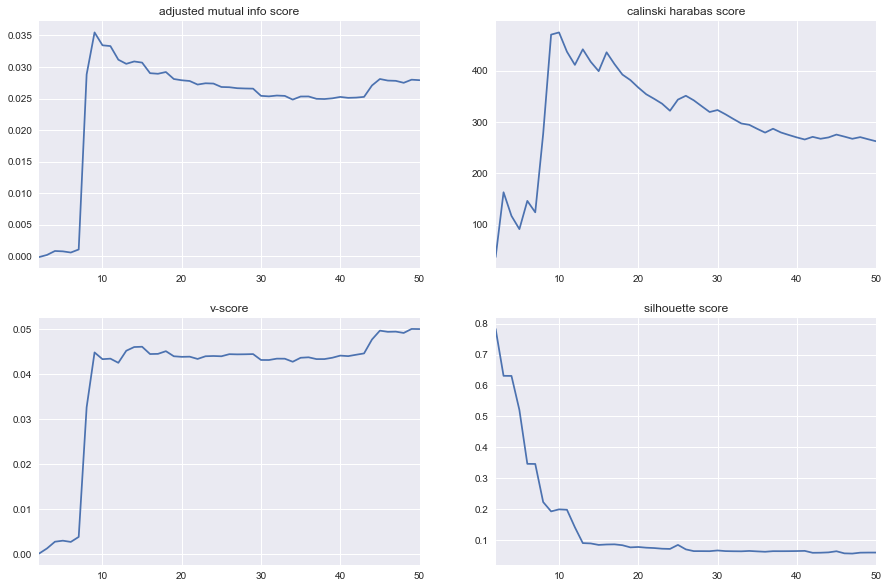

In [17]:
evaluate_hclust(y, complete)

#### Ward

In [22]:
ward = linkage(pdist(X), 'ward')

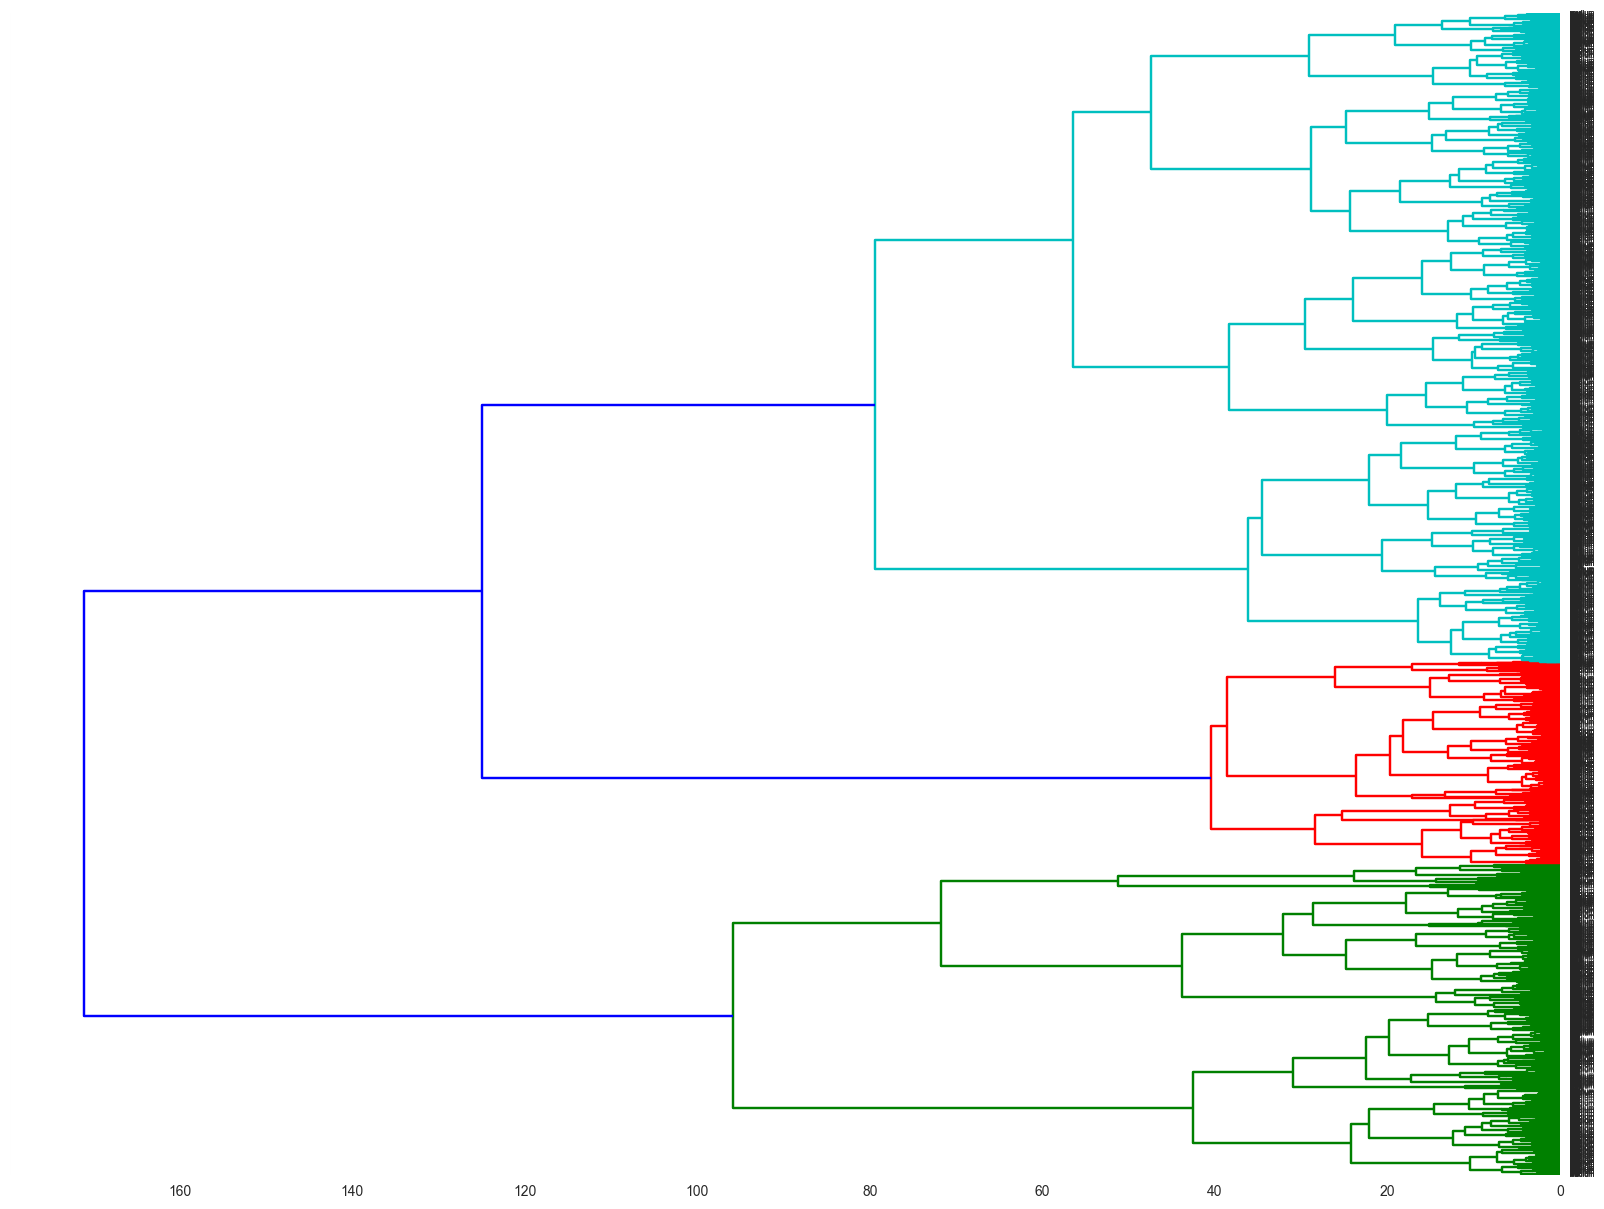

In [45]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = dendrogram(ward, orientation='left', labels=y, ax=ax)

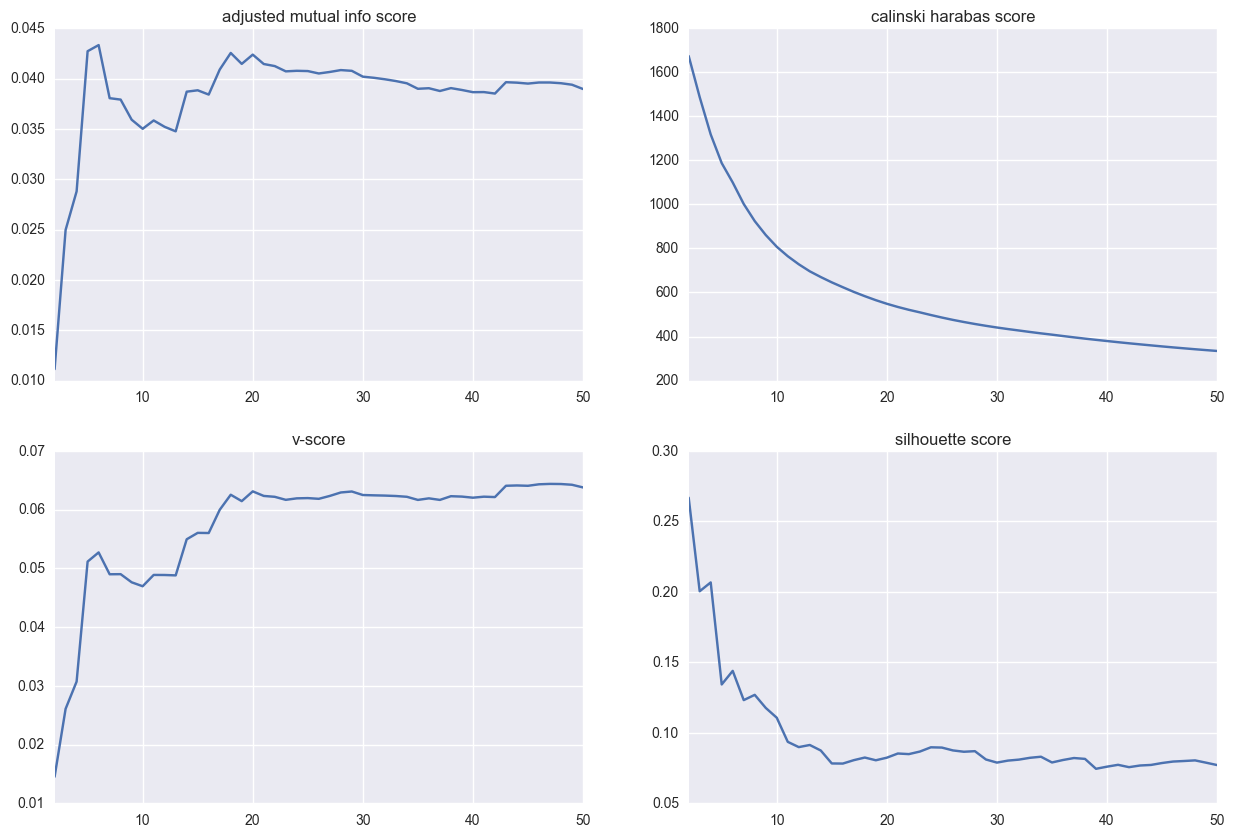

In [27]:
evaluate_hclust(y, ward)


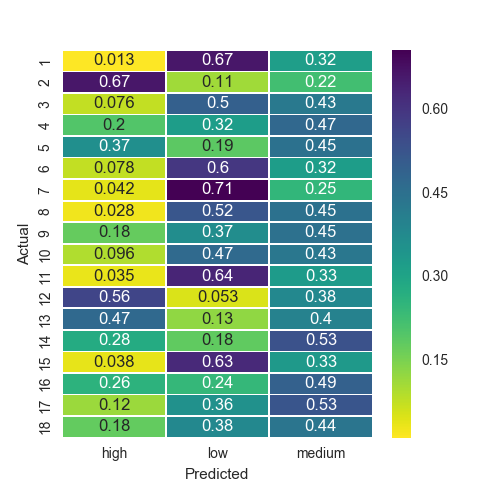

In [49]:
clusters = fcluster(ward, 18, 'maxclust')

metrics.fowlkes_mallows_score(y,clusters)
HTML(confusion_matrix_picture(clusters,y,fs=5))


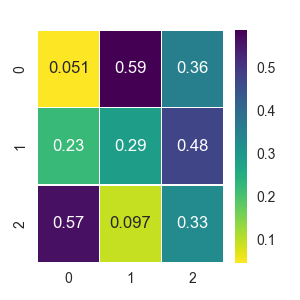

In [287]:
clusters = fcluster(ward, 18, 'maxclust')
mm=np.array(confusion_matrix_simple(clusters,y))
from scipy.spatial import distance_matrix, distance
dst=np.zeros([len(mm), len(mm)])
for k in range(len(mm)):
    for j in range(len(mm)):
        dst[k,j]=distance.cosine(mm[k],mm[j])

clust = KMeans(n_clusters = 3, max_iter=5000, algorithm='full').fit(mm)
clusters = clust.predict(mm)

HTML(clust_matrix_picture(clust.cluster_centers_, fs=3))

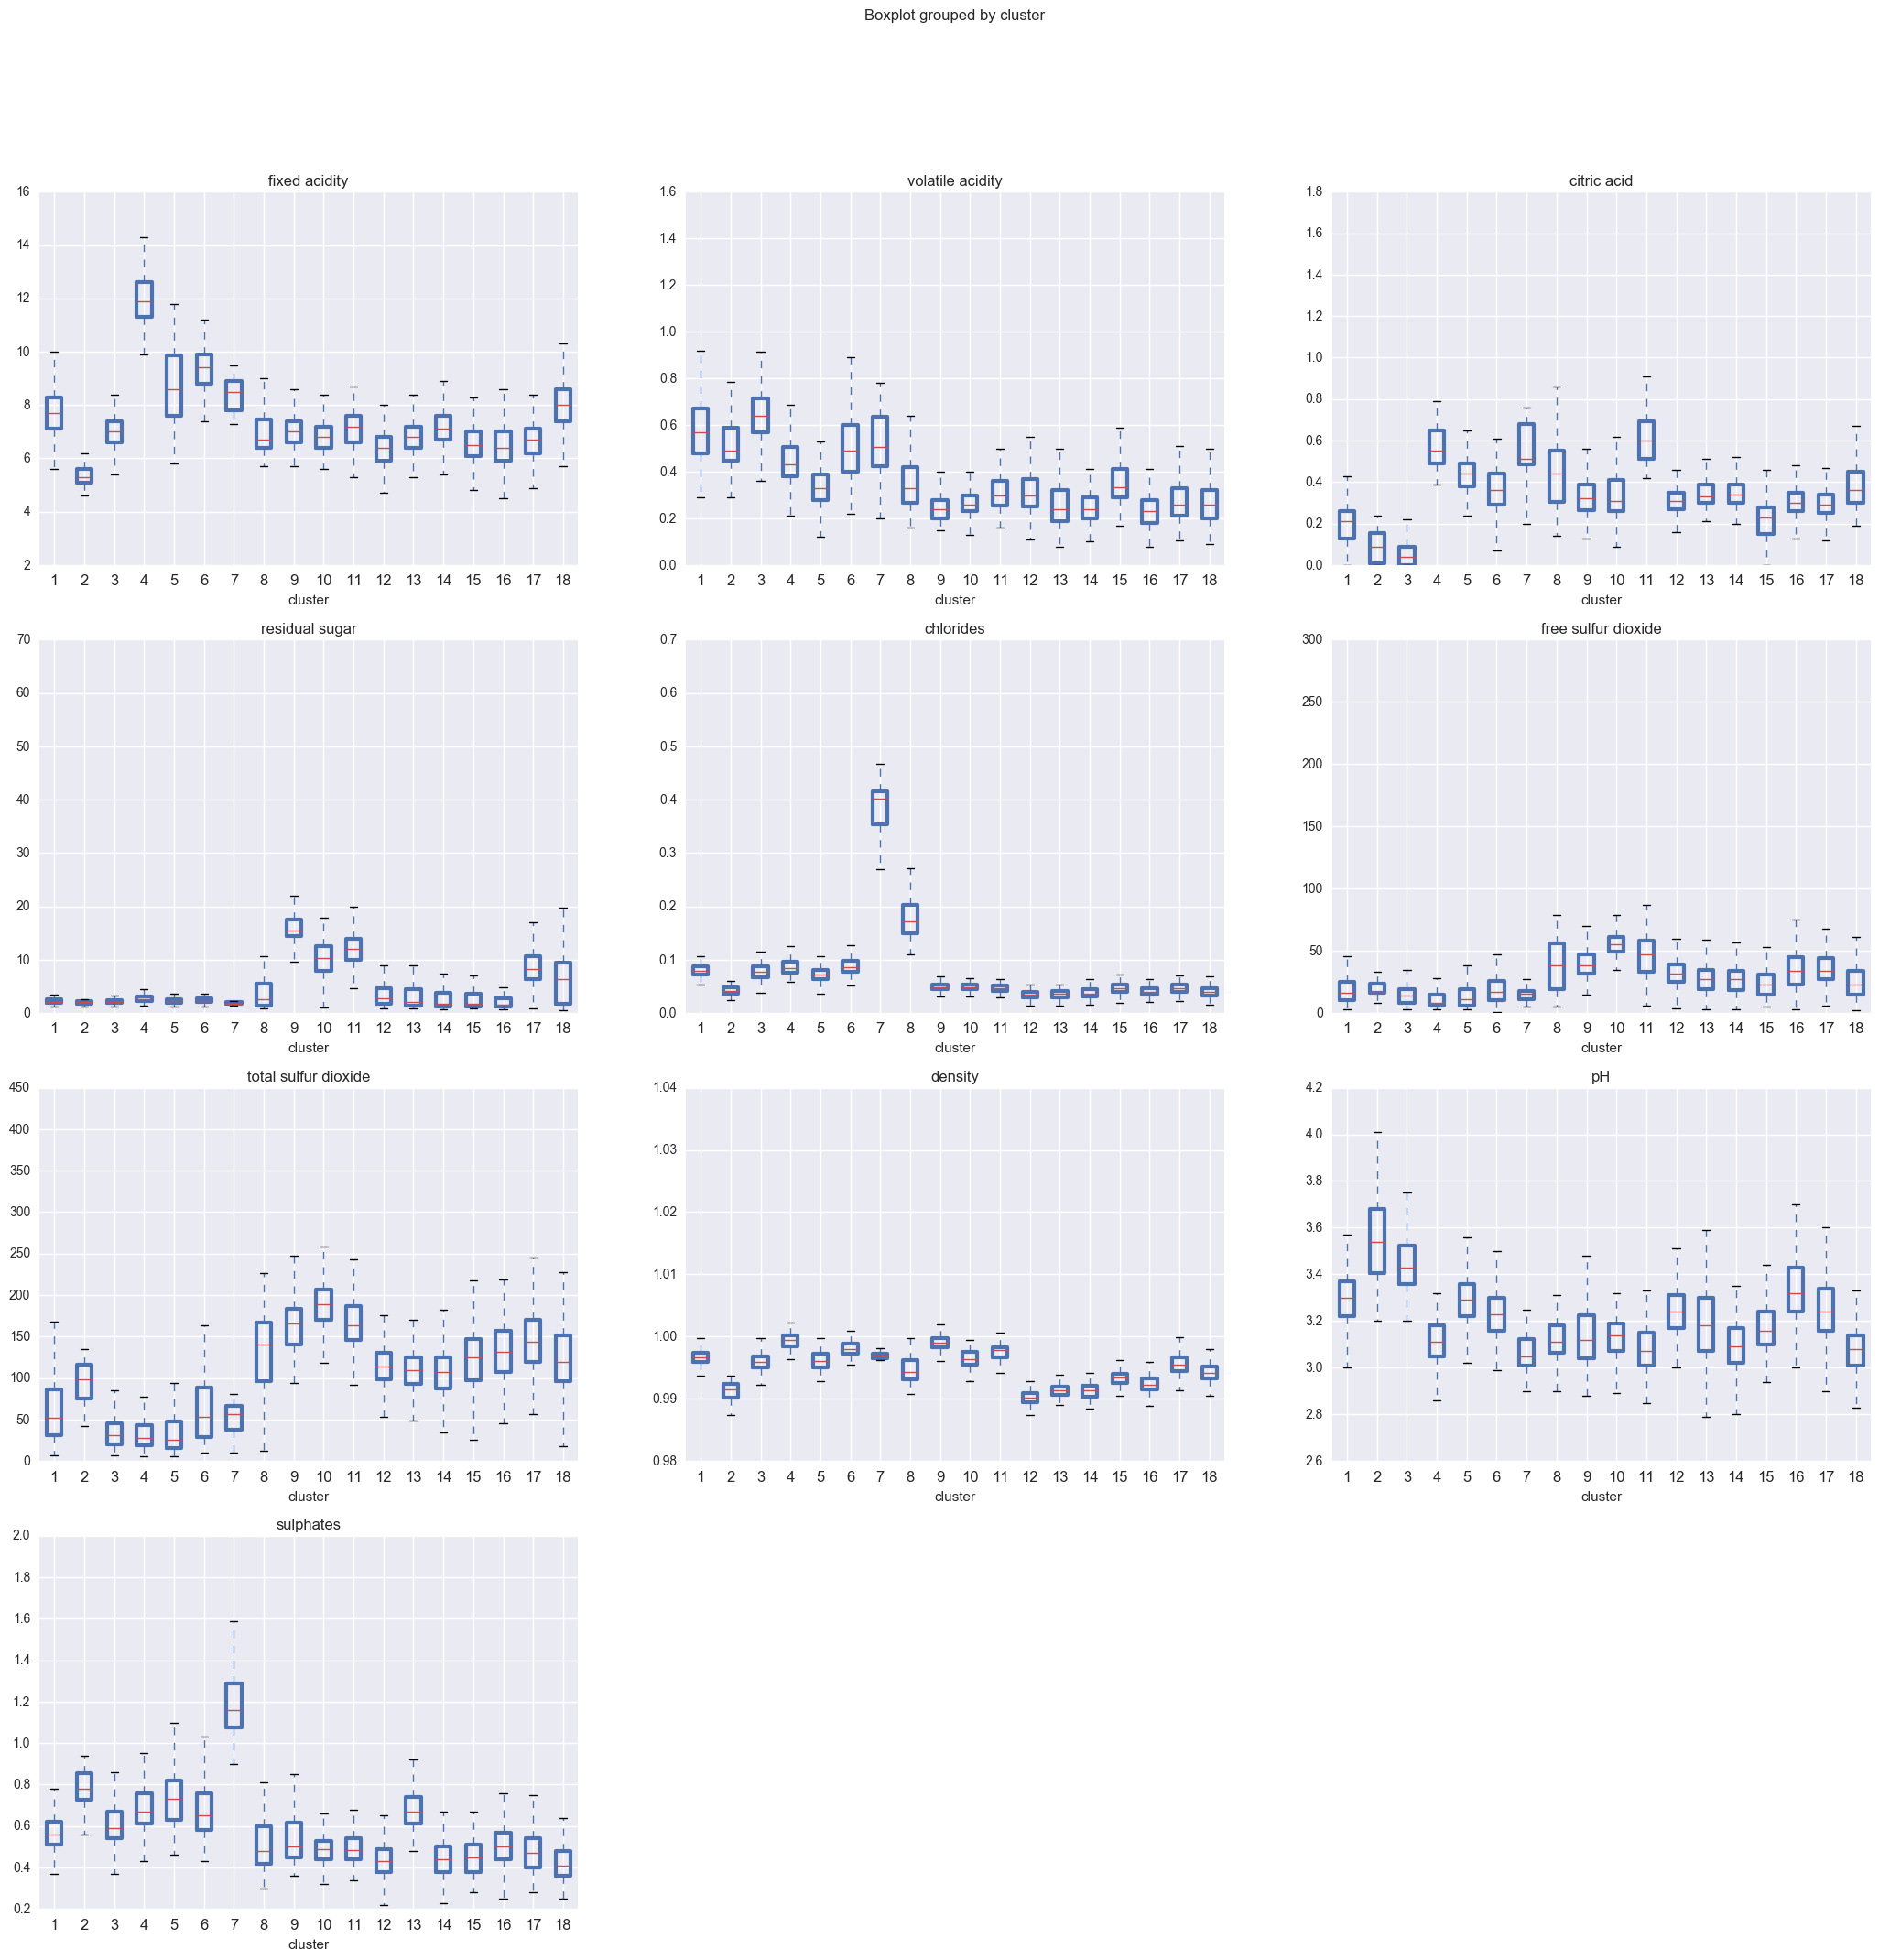

In [291]:
clusters = fcluster(ward, 18, 'maxclust')
plt.figure(figsize=[25,25])
k=0
for nm in df.columns[0:10]:
    k=k+1
    ax=plt.subplot(4,3,k)
    ddf=pd.DataFrame({nm:df[nm], 'cluster':clusters})
    ddf.boxplot(nm, 'cluster', ax=ax, boxprops=dict(linestyle='-', linewidth=3, color='k'))

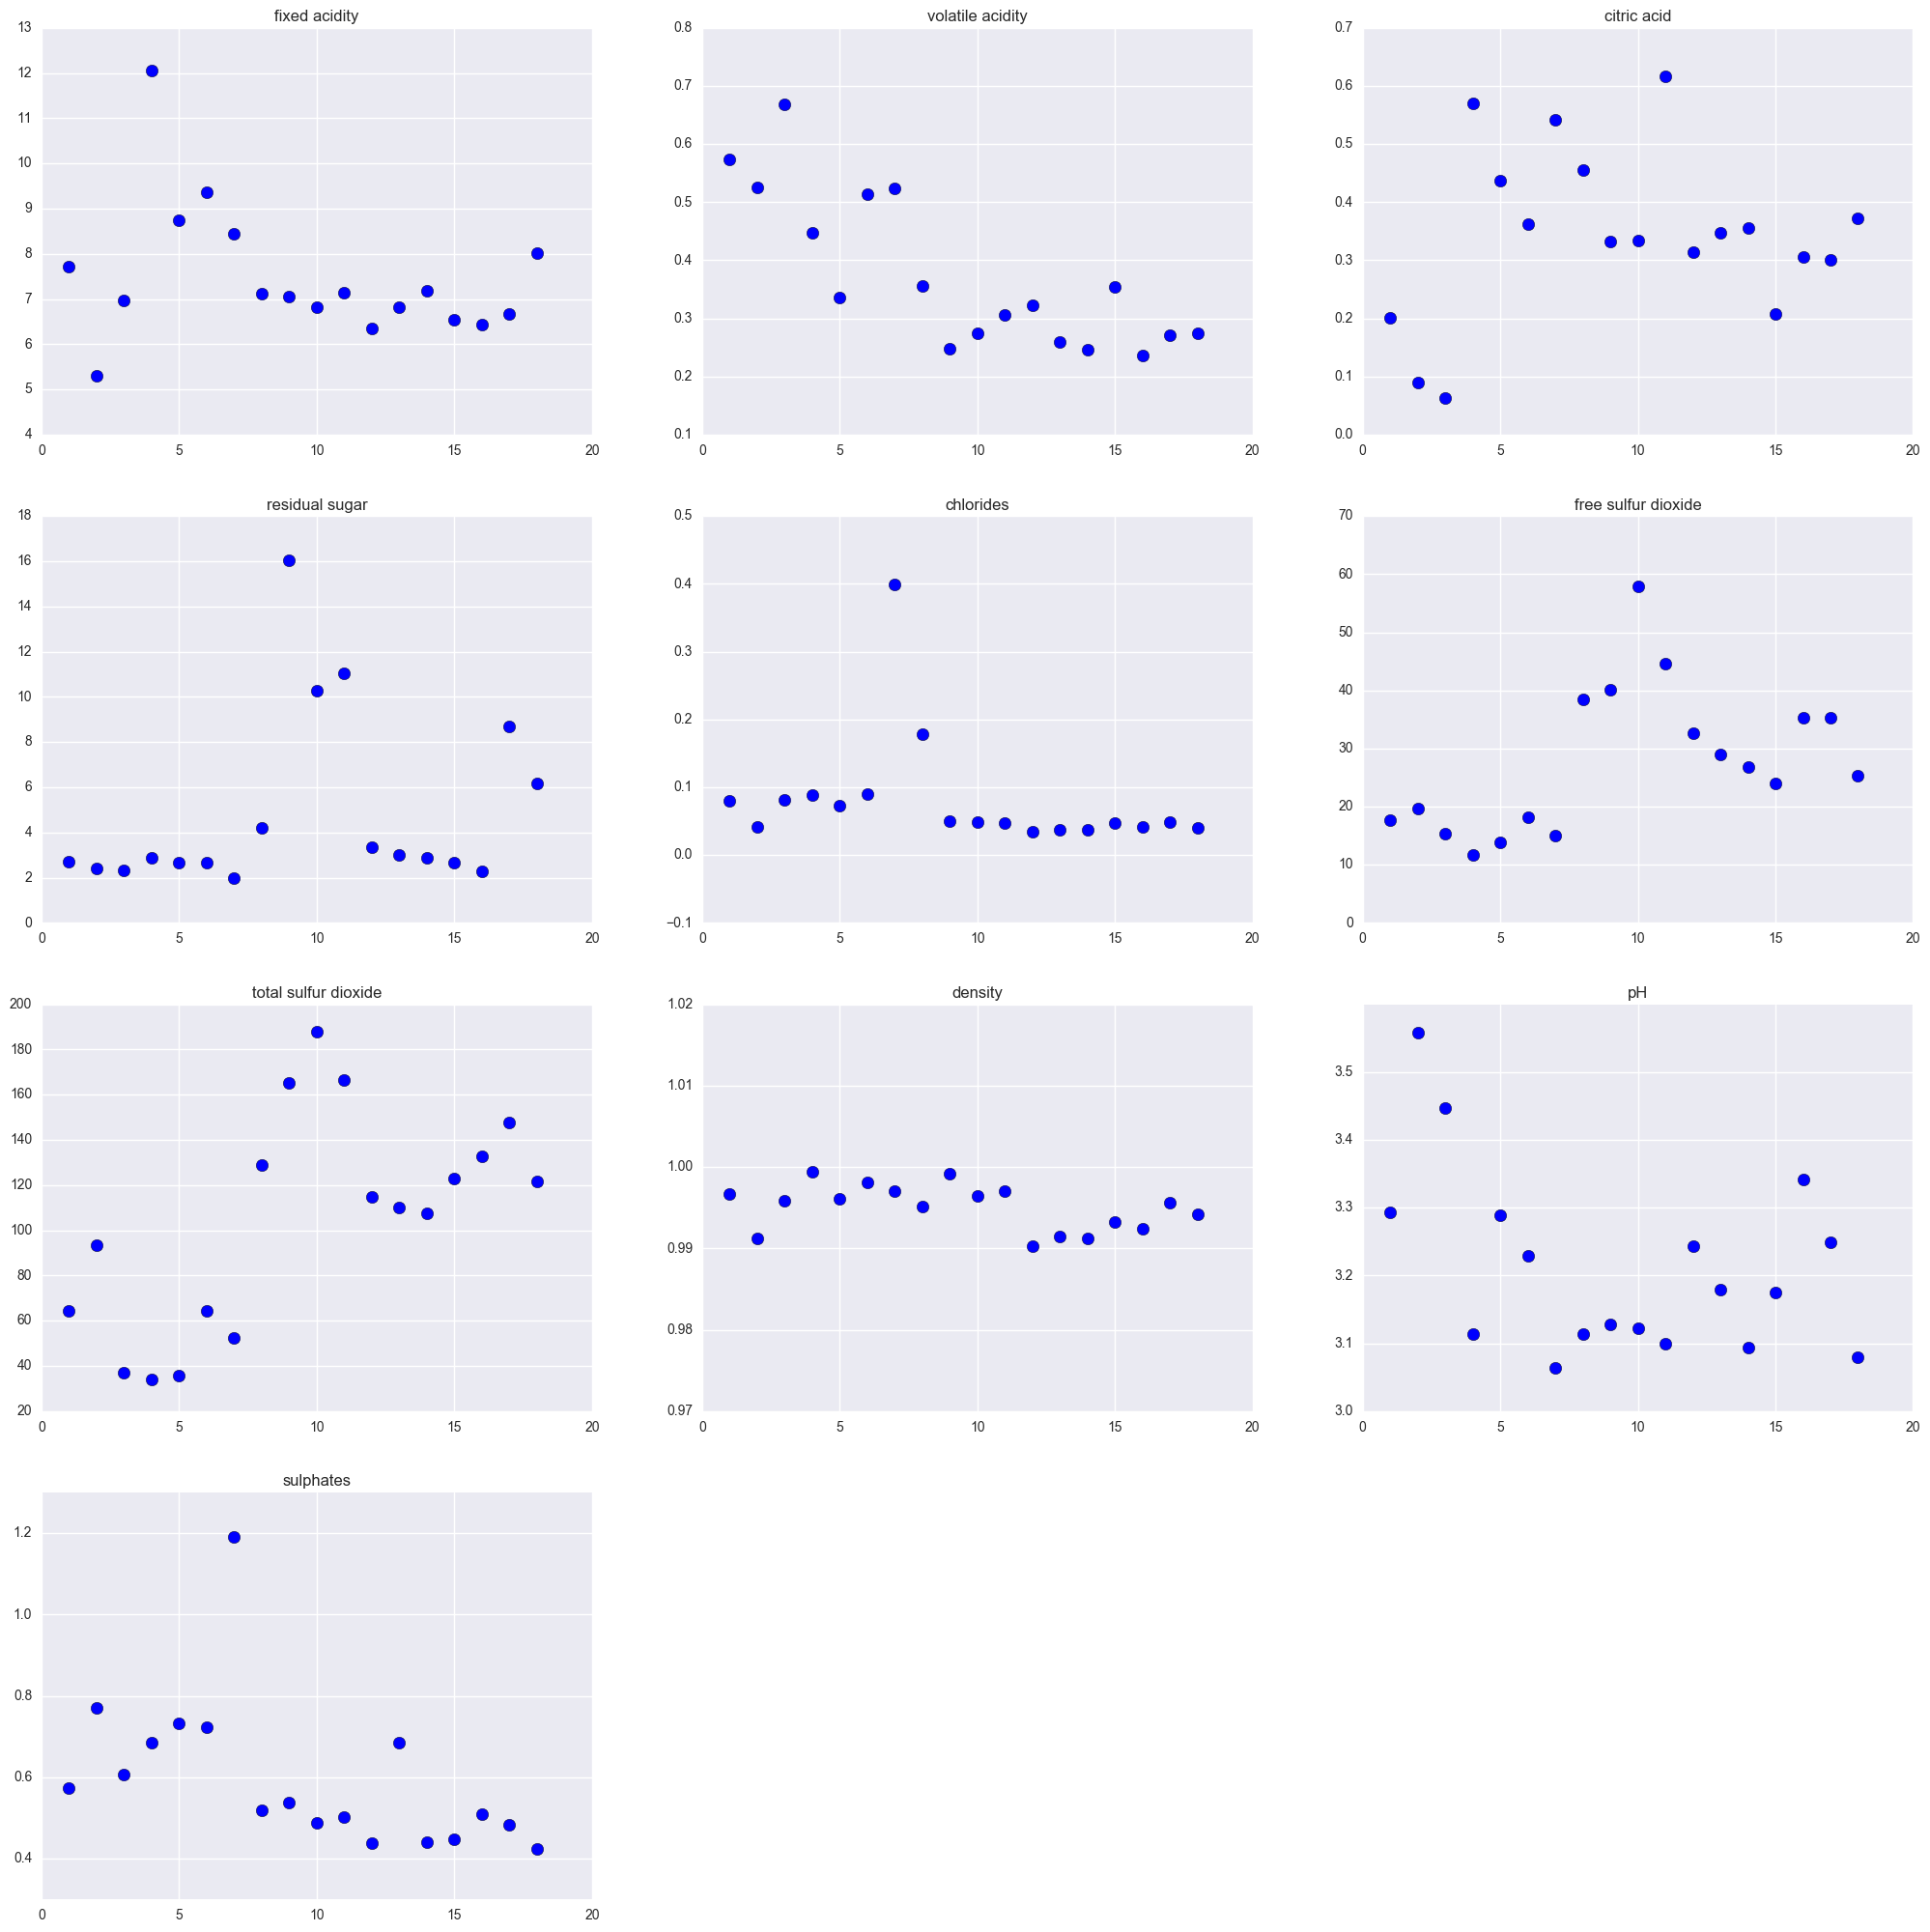

In [309]:
clusters = fcluster(ward, 18, 'maxclust')
plt.figure(figsize=[25,25])
k=0
for nm in df.columns[0:10]:
    k=k+1
    ax=plt.subplot(4,3,k)
    ddf=pd.DataFrame({nm:df[nm], 'cluster':clusters})
    plt.scatter(np.unique(ddf['cluster']),ddf.groupby(['cluster'])[nm].mean(), s=80)
    plt.title(nm)


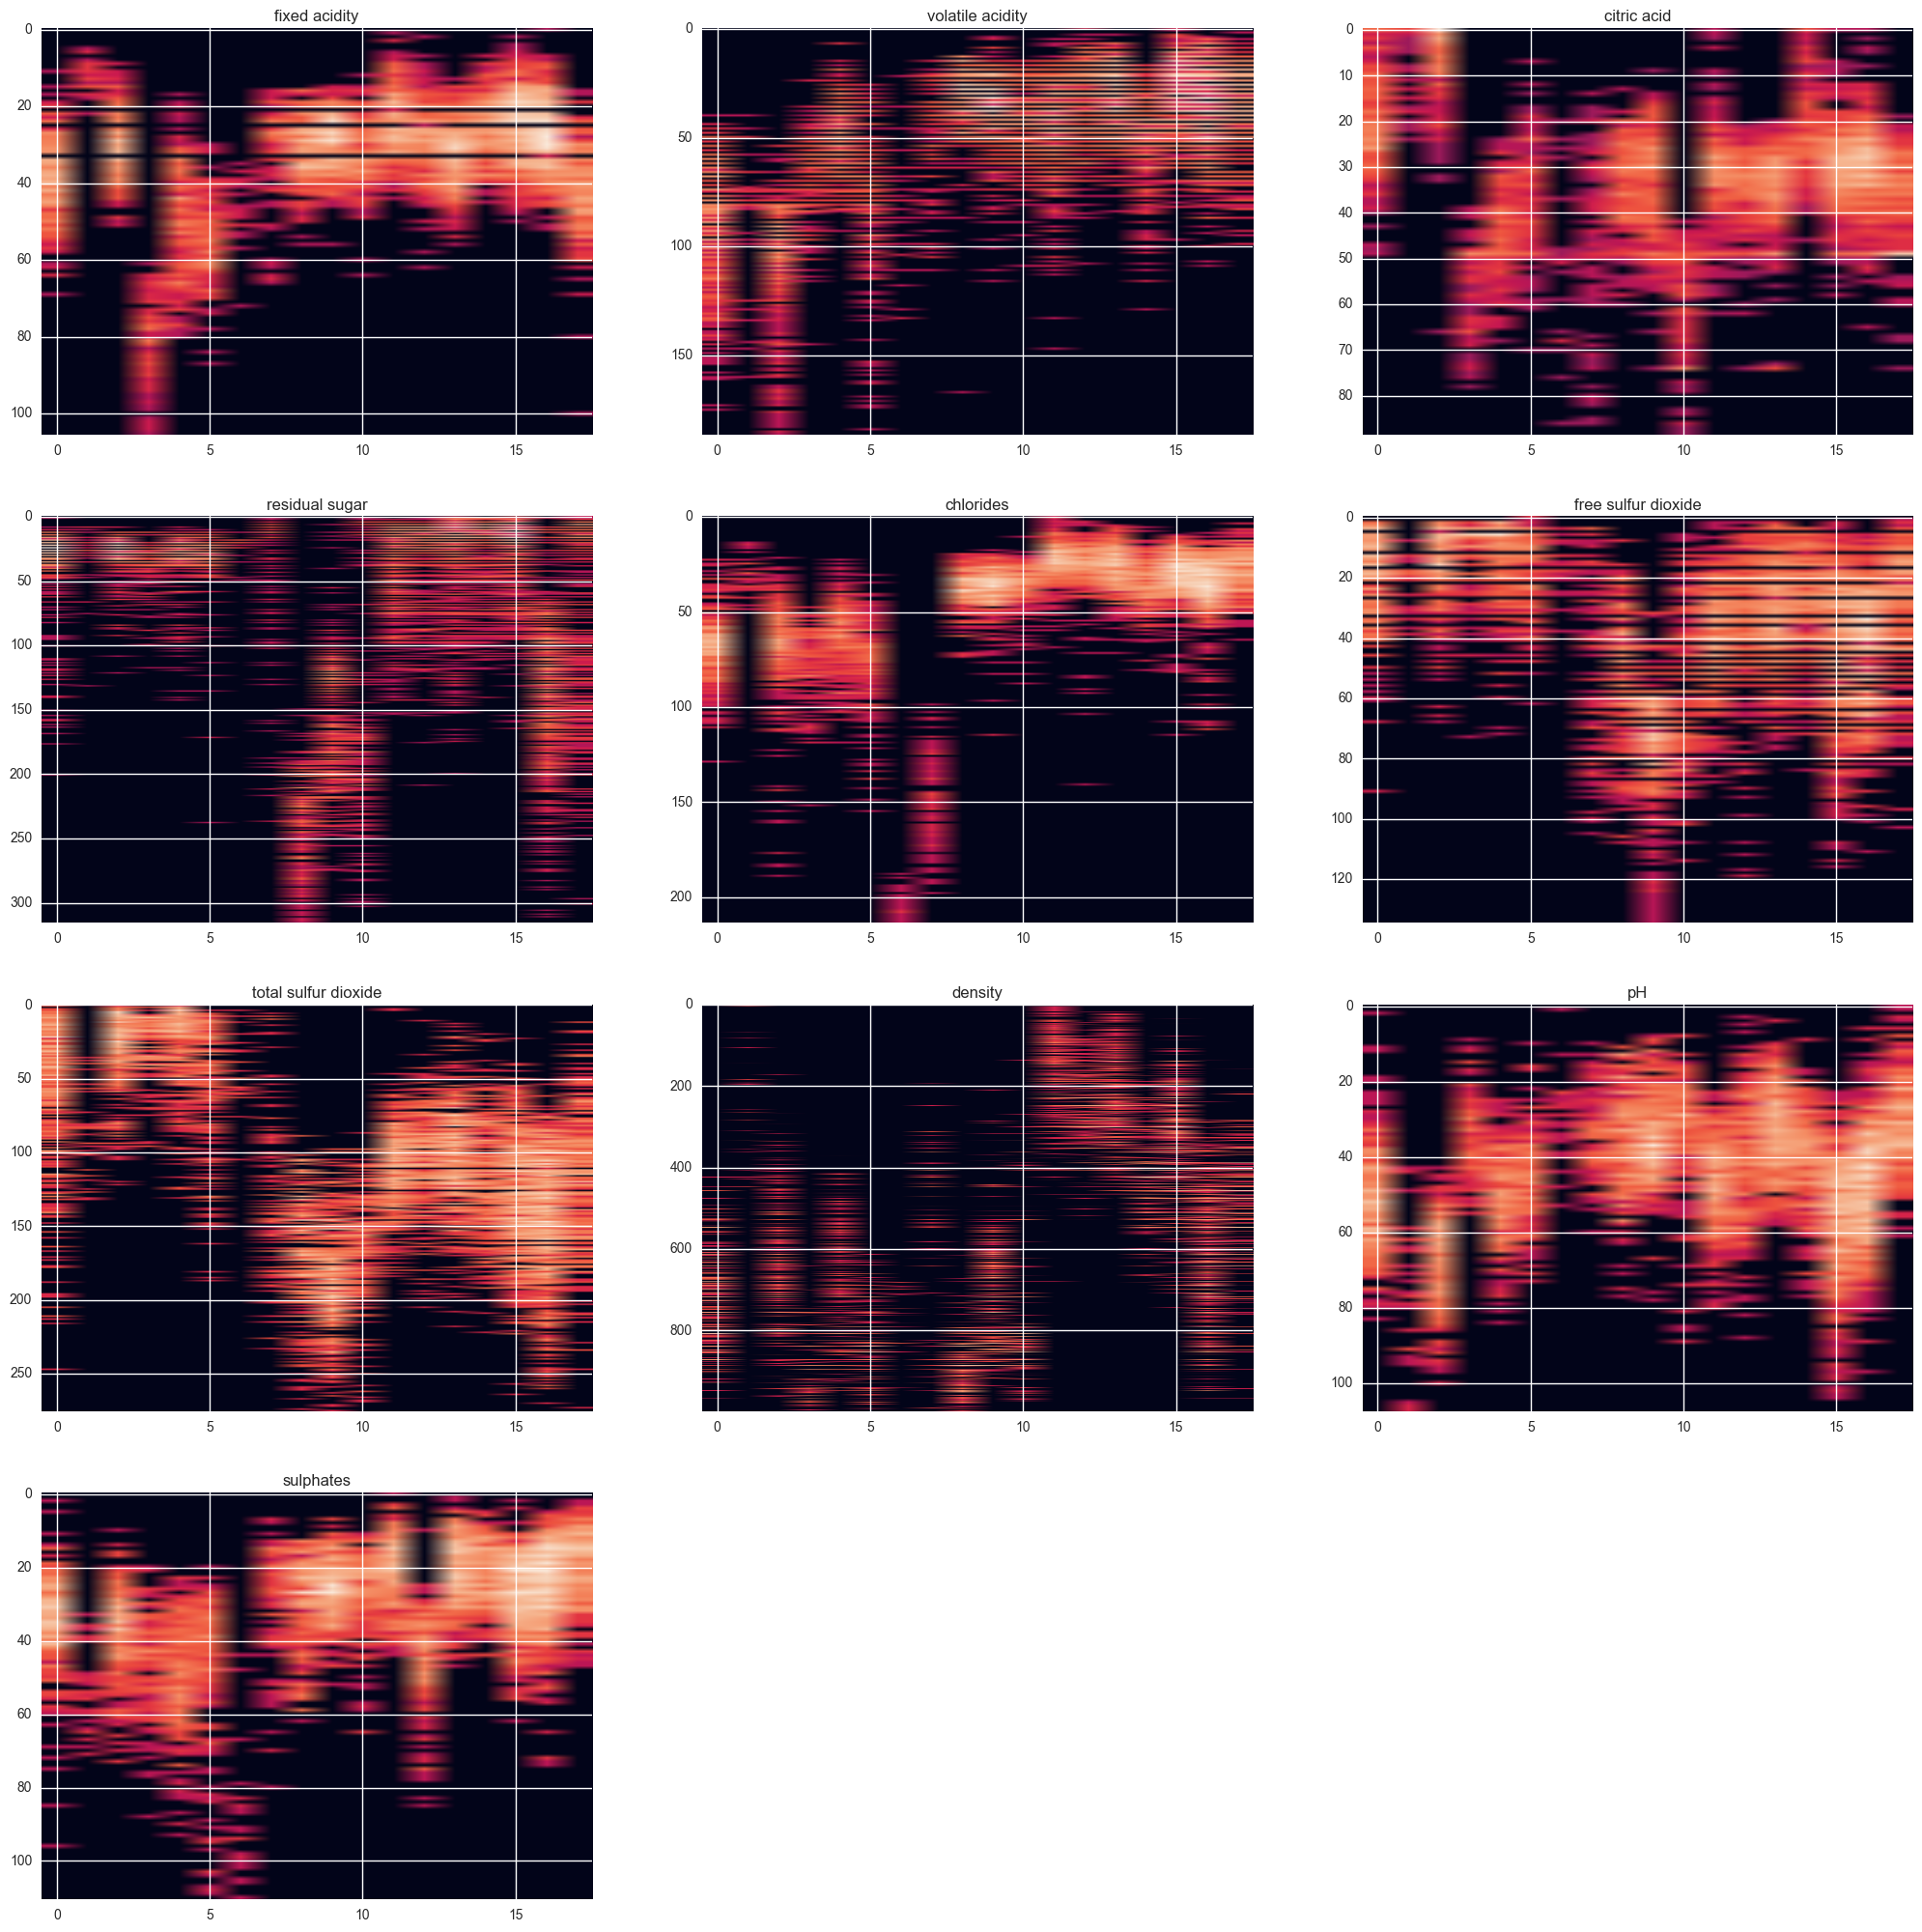

In [323]:
clusters = fcluster(ward, 18, 'maxclust')
plt.figure(figsize=[25,25])
k=0
for nm in df.columns[0:10]:
    k=k+1
    ax=plt.subplot(4,3,k)
    ddf=pd.DataFrame({nm:df[nm], 'cluster':clusters})
    plt.imshow(np.array(pd.crosstab( ddf[nm], ddf['cluster']))**0.2,aspect='auto' )
    plt.title(nm)

#plt.imshow(np.array(pd.crosstab( ddf[nm], ddf['cluster']))**0.8,aspect='auto' )